In [1]:
import tensorflow as tf

In [2]:
# %load_ext autoreload
# %autoreload 2

from fastai2.vision.all import *
from fastai2.callback.data import partial_dataloaders

from statistics import stdev
from tfrecord.tfrecord import *
import gc

We'll work out of the 224x224 image set, but of course we can modify this however we want!

In [3]:
path = Path('../data/flowers/tfrecords-jpeg-224x224')

In [4]:
train_fnames = get_files(path/'train', extensions='.tfrec')
test_fnames = get_files(path/'val', extensions='.tfrec')

In order to parse the data, we need to "unpack" each sample to bring it into a `Dataset`. `tfrecord` has two special functions we can use, `unpack_int_64_list` and `unpack_bytes_list` (our classes are integers and our images are bytes)

In [5]:
def unpack_sample(feats):
    return {
        'class' : unpack_int64_list(feats['class']),
        'image' : unpack_bytes_list(feats['image'])
    }

The current file situation (for this folder) is like so:

* 16 `tfrecord` files each with 792 images for training and testing

How would we split with that? We'll use an index splitter for everything after 12753

In [6]:
data = []
for name in train_fnames+test_fnames:
    r = Reader(str(name), unpack_sample)
    for sample in r:
        data.append([sample['image'][0], sample['class'][0]])

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [7]:
len(data)

16465

Now we'll make our getters. They'll operate by grabbing the first and second items from a particular `x`

In [8]:
get_x = lambda o: PILImage.create(io.BytesIO(o[0]))
get_y = lambda o: o[1]

In [9]:
def get_items(noop): return data

In [10]:
splitter = IndexSplitter(range(12753, len(data)))

In [11]:
def xresnet50_splitter(model):
    "Split the classifier head from the backbone"
    groups = [nn.Sequential(*list(model.children())[:8])]
    groups = L(groups + [nn.Sequential(*list(model.children())[8:])]) 
    return groups.map(params)

In [12]:
# data=data[:1000]
# def get_items(noop): return data
# splitter = IndexSplitter(range(500, len(data)))

In [13]:
# block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
#                   get_items=get_items,
#                   get_x=get_x,
#                   get_y=get_y,
#                   splitter=splitter,
#                   item_tfms=[Resize(224)],
#                   batch_tfms=[*aug_transforms()])

In [14]:
# dls = block.dataloaders('', bs=64)
# len(dls.train), len(dls.valid), dls.c

In [15]:
#dls.show_batch()

Now we'll build a model and train!

In [16]:
# import ipywidgets as widgets
# from IPython.display import display

# def highlight(s, usemax=True):    
#     if usemax:
#         is_max = s == s.max()
#     else:
#         is_max = s == s.min()
#     return ['border: 1px solid red; font-weight: bold;' if v else '' for v in is_max]

# class ColorfulProgressCallback(ProgressCallback):
#     def __init__(self):
#         super()
        
#     def begin_fit(self):
#         super().begin_fit()
#         self.widget = widgets.Output()
#         if(hasattr(self, 'out')): delattr(self, 'out')
#         for i, cb in enumerate(self.learn.cbs):
#             if type(cb) == ProgressCallback:
#                 self.learn.cbs[i] = self
            
#     def after_fit(self):
#         super().after_fit()
#         #if(hasattr(self, 'all_log')): delattr(self, 'all_log')
        
#     def _write_stats(self, log):
#         print(log)
        
#         if(not hasattr(self, 'all_log')):
#             self.all_log = pd.DataFrame([], columns=log)
#             return
        
#         #print(self.widget)
        
#         with self.widget:
#             print('IN SELF.WIDGET')
#             self.all_log.loc[len(self.all_log)] = [l if isinstance(l, float) else str(l) for l in log]
#             for c in self.all_log.columns[1:-1]:
#                 self.all_log[c] = self.all_log[c].astype(float)
                
#             s = self.all_log.style
#             for c in self.all_log.columns[1:-1]:
#                 isR2 = 'R2' in c
#                 low = .8 if isR2 else .2
#                 high = .2 if isR2 else .8
#                 s = s.background_gradient(cmap=f'viridis{"_r" if not isR2 else ""}', subset=c, low=low, high=high)
#                 s.apply(partial(highlight, usemax=isR2), subset=[c])
#             s = s.hide_index()
            
#             if(hasattr(self, 'out')):
#                 self.out.update(s)
#             else:
#                 self.out = display(s, display_id=True)

In [17]:
from fastai2.basics import *
from fastai2.callback.progress import *
from fastai2.callback.hook import total_params

In [18]:
from fastai2.callback.wandb import *
import wandb
wandb.init()

W&B Run: https://app.wandb.ai/morgan/uncategorized/runs/6alse1w4

# 1. Baseline 224

In [18]:
def get_dls(sz=224):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[*aug_transforms()])
    dls = block.dataloaders('', bs=64)
    return dls

In [19]:
def do_train(runs=1,  num_ep=5, lr1=1e-2, lr2=2e-3):
    acc_res,val_res=[],[]
    #stg_1_num_ep = 1
    cbs=[] #[WandbCallback()]  #[ColorfulProgressCallback()]
    for r in range(runs):
        print(f'Run: {r+1}')
        
        # GET LEARNER
        m=xresnet50(pretrained=False, sa=True, act_cls=Mish)
        loss_func=LabelSmoothingCrossEntropy()
        
        # STG 1
        dls = get_dls(sz=224)
        learn = Learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, cbs=cbs).to_fp16()
        # TRAIN
        learn.unfreeze()
        learn.fit_flat_cos(num_ep, lr1, cbs=cbs)
        
        # LOG
        acc_res.append(learn.final_record[2])
        val_res.append(learn.final_record[1])
        # CLEAR MEM
        if r < runs-1:
            learn=None
            del learn
            torch.cuda.empty_cache()
            gc.collect()
            print('')
    
    if len(acc_res) > 1:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}% ±{(stdev(acc_res)*100):.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f} ±{stdev(val_res):.2f}')
    else:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f}')
    return acc_res, val_res, learn

In [20]:
do_train(runs=5, num_ep=5, lr1=1e-2)

Run: 1
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.662053,3.504517,0.282058,00:56
1,3.209553,3.045265,0.409752,00:54
2,2.835319,2.719506,0.502963,00:54
3,2.499630,2.685295,0.538793,00:54
4,2.028268,2.058810,0.718481,00:55



Run: 2
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.599114,3.486315,0.323276,00:54
1,3.116153,3.040761,0.409752,00:55
2,2.779336,2.746026,0.500269,00:55
3,2.531446,2.514803,0.575162,00:55
4,2.082849,2.127303,0.696121,00:55



Run: 3
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.610059,3.353704,0.326239,00:54
1,3.121909,3.087715,0.395744,00:55
2,2.791780,2.701177,0.517780,00:55
3,2.538214,2.499420,0.570851,00:55
4,2.109695,2.113142,0.700162,00:55



Run: 4
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.643347,3.300817,0.332166,00:54
1,3.171241,2.989561,0.425377,00:55
2,2.849014,2.708453,0.502425,00:55
3,2.558851,2.690996,0.527209,00:55
4,2.072507,2.127432,0.693427,00:55



Run: 5
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.614480,3.357518,0.340787,00:54
1,3.105870,3.012425,0.447737,00:55
2,2.770127,2.656654,0.530172,00:55
3,2.492348,2.323840,0.626078,00:55
4,2.045340,2.052896,0.719289,00:55


Average Val Acc: 70.55% ±1.25%
Average Val Loss: 2.10 ±0.04


([0.7184805870056152,
  0.6961206793785095,
  0.7001616358757019,
  0.6934267282485962,
  0.7192887663841248],
 [2.0588104724884033,
  2.127303123474121,
  2.113142251968384,
  2.127431869506836,
  2.0528955459594727],
 <fastai2.learner.Learner at 0x7f7dcc3bfed0>)

# 2. Baseline 224, RRC

In [20]:
def get_dls(sz=224):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[RandomResizedCrop(sz, min_scale=0.7)],
                      batch_tfms=[*aug_transforms()])
    dls = block.dataloaders('', bs=64)
    return dls

In [21]:
def do_train(runs=1,  num_ep=5, lr1=1e-2, lr2=2e-3):
    acc_res,val_res=[],[]
    #stg_1_num_ep = 1
    cbs=[] #[ColorfulProgressCallback()]
    for r in range(runs):
        print(f'Run: {r+1}')
        
        cbs=[] #[WandbCallback()]
        # GET LEARNER
        m=xresnet50(pretrained=False, sa=True, act_cls=Mish)
        loss_func=LabelSmoothingCrossEntropy()
        
        # STG 1
        dls = get_dls(sz=224)
        learn = Learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, cbs=cbs).to_fp16()
        # TRAIN
        learn.unfreeze()
        #learn.fit(num_ep, lr1)
        learn.fit_flat_cos(num_ep, lr1, cbs=cbs)
        
#         # STG 2
#         dls = get_dls(sz=224)
#         learn.dls = dls
#         learn.fit_flat_cos(num_ep-stg_1_num_ep, lr2, cbs=cbs, pct_start=0.85)
        
        # LOG
        acc_res.append(learn.final_record[2])
        val_res.append(learn.final_record[1])
        # CLEAR MEM
        if r < runs-1:
            learn=None
            del learn
            torch.cuda.empty_cache()
            gc.collect()
            print('')
    
    if len(acc_res) > 1:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}% ±{(stdev(acc_res)*100):.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f} ±{stdev(val_res):.2f}')
    else:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f}')
    return acc_res, val_res, learn

In [22]:
do_train(runs=5, num_ep=5, lr1=1e-2)

Run: 1
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.652795,3.327855,0.337554,00:57
1,3.159473,2.983436,0.427802,00:54
2,2.899125,2.795834,0.488416,00:54
3,2.675782,2.547404,0.553879,00:55
4,2.209069,2.184587,0.668373,00:55



Run: 2
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.634965,3.438715,0.308998,00:55
1,3.157825,2.953031,0.430226,00:55
2,2.869650,2.657932,0.512392,00:55
3,2.604079,2.529299,0.559537,00:55
4,2.160663,2.134553,0.682651,00:55



Run: 3
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.657764,3.321641,0.332435,00:54
1,3.157112,3.050685,0.404903,00:55
2,2.877803,2.677924,0.507274,00:55
3,2.653222,2.590335,0.529903,00:55
4,2.205002,2.191128,0.671336,00:55



Run: 4
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.655037,3.300853,0.345636,00:55
1,3.170337,3.068143,0.397899,00:55
2,2.852800,2.763567,0.512662,00:55
3,2.620161,2.601039,0.537177,00:55
4,2.173027,2.143682,0.679957,00:55



Run: 5
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.608113,3.320966,0.332974,00:55
1,3.178930,2.935350,0.436153,00:55
2,2.887678,3.085530,0.405981,00:55
3,2.622716,2.480130,0.567619,00:55
4,2.161296,2.121583,0.689116,00:55


Average Val Acc: 67.83% ±0.85%
Average Val Loss: 2.16 ±0.03


([0.6683728694915771,
  0.6826508641242981,
  0.6713362336158752,
  0.6799569129943848,
  0.689116358757019],
 [2.184587240219116,
  2.1345529556274414,
  2.1911277770996094,
  2.143681764602661,
  2.1215829849243164],
 <fastai2.learner.Learner at 0x7fd0b16e1a50>)

# 2b. Baseline 224, RRC

In [20]:
def get_dls(sz=224):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[RandomResizedCrop(sz, min_scale=0.35)],
                      batch_tfms=[*aug_transforms()])
    dls = block.dataloaders('', bs=64)
    return dls

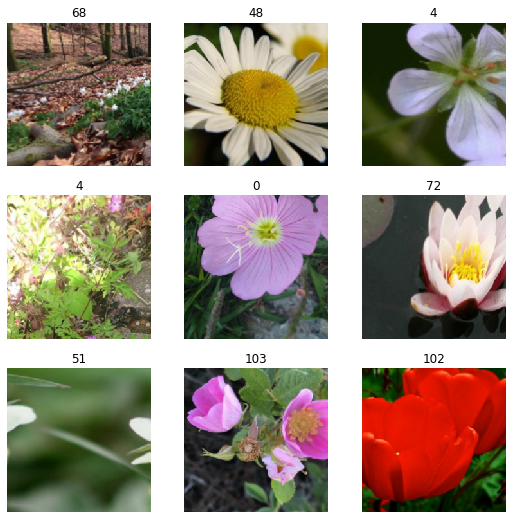

In [23]:
dls = get_dls(sz=224)
dls.show_batch()

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.25118863582611084)

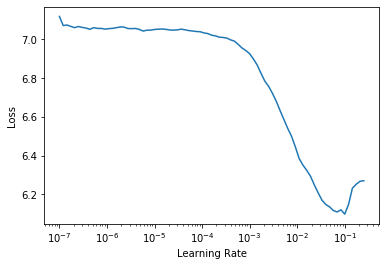

In [19]:
cbs=[] #[WandbCallback()]
# GET LEARNER
m=xresnet50(pretrained=False, sa=True, act_cls=Mish)
loss_func=LabelSmoothingCrossEntropy()

# STG 1
dls = get_dls(sz=224)
learn = Learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, cbs=cbs).to_fp16()
# TRAIN
learn.unfreeze()
learn.lr_find()

In [21]:
def do_train(runs=1,  num_ep=5, lr1=1e-2, lr2=2e-3):
    acc_res,val_res=[],[]
    #stg_1_num_ep = 1
    cbs=[] #[ColorfulProgressCallback()]
    for r in range(runs):
        print(f'Run: {r+1}')
        
        cbs=[] #[WandbCallback()]
        # GET LEARNER
        m=xresnet50(pretrained=False, sa=True, act_cls=Mish)
        loss_func=LabelSmoothingCrossEntropy()
        
        # STG 1
        dls = get_dls(sz=224)
        learn = Learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, cbs=cbs).to_fp16()
        # TRAIN
        learn.unfreeze()
        #learn.fit(num_ep, lr1)
        learn.fit_flat_cos(num_ep, lr1, pct_start=0.5, cbs=cbs)
        
#         # STG 2
#         dls = get_dls(sz=224)
#         learn.dls = dls
#         learn.fit_flat_cos(num_ep-stg_1_num_ep, lr2, cbs=cbs, pct_start=0.85)
        
        # LOG
        acc_res.append(learn.final_record[2])
        val_res.append(learn.final_record[1])
        # CLEAR MEM
        if r < runs-1:
            learn=None
            del learn
            torch.cuda.empty_cache()
            gc.collect()
            print('')
    
    if len(acc_res) > 1:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}% ±{(stdev(acc_res)*100):.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f} ±{stdev(val_res):.2f}')
    else:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f}')
    return acc_res, val_res, learn

In [22]:
do_train(runs=5, num_ep=5, lr1=1e-2)

Run: 1
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.671283,3.420634,0.309806,00:56
1,3.202745,3.191276,0.377963,00:54
2,2.932585,2.823953,0.488147,00:54
3,2.542186,2.380608,0.608028,00:55
4,2.201675,2.197366,0.665948,00:55



Run: 2
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.696070,3.448028,0.306034,00:54
1,3.222017,3.107756,0.382004,00:55
2,2.893828,2.831213,0.467403,00:55
3,2.523649,2.434939,0.585129,00:55
4,2.231580,2.224483,0.659483,00:55



Run: 3
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.674461,3.632663,0.265086,00:54
1,3.258823,3.059567,0.400054,00:55
2,2.953249,2.773468,0.474138,00:55
3,2.549669,2.413361,0.599407,00:55
4,2.225369,2.226977,0.653017,00:55



Run: 4
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.669228,3.317778,0.339170,00:55
1,3.178241,2.919139,0.449084,00:55
2,2.910847,2.775285,0.501078,00:55
3,2.520856,2.371689,0.609106,00:55
4,2.197199,2.194880,0.663793,00:55



Run: 5
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.699040,3.475397,0.301455,00:54
1,3.225313,3.390174,0.323006,00:55
2,2.932793,2.827113,0.478718,00:55
3,2.522105,2.387706,0.592134,00:55
4,2.195360,2.201683,0.673491,00:55


Average Val Acc: 66.31% ±0.76%
Average Val Loss: 2.21 ±0.02


([0.6659482717514038,
  0.6594827771186829,
  0.6530172228813171,
  0.6637930870056152,
  0.673491358757019],
 [2.197366237640381,
  2.2244832515716553,
  2.2269771099090576,
  2.194880247116089,
  2.2016830444335938],
 <fastai2.learner.Learner at 0x7fddc29eee90>)

# 3. FixRes 192/224, RRC

In [20]:
def get_dls(sz=224):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[RandomResizedCrop(sz, min_scale=0.7)],
                      batch_tfms=[*aug_transforms()])
    dls = block.dataloaders('', bs=64)
    return dls

In [21]:
def do_train(runs=1,  num_ep=5, lr1=1e-2, lr2=2e-3):
    acc_res,val_res=[],[]
    stg_1_num_ep = 4
    cbs=[] #[ColorfulProgressCallback()]
    for r in range(runs):
        print(f'Run: {r+1}')
        
        cbs=[] #[WandbCallback()]
        # GET LEARNER
        m=xresnet50(pretrained=False, sa=True, act_cls=Mish)
        loss_func=LabelSmoothingCrossEntropy()
        
        # STG 1
        dls = get_dls(sz=192)
        learn = Learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, 
                        splitter=xresnet50_splitter, cbs=cbs).to_fp16()
        # TRAIN
        learn.unfreeze()
        #learn.fit(num_ep, lr1)
        learn.fit(stg_1_num_ep, lr1, cbs=cbs)
        
        # STG 2
        new_dls = get_dls(sz=224)
        learn.dls = new_dls
        learn.freeze()
        learn.fit_flat_cos(num_ep-stg_1_num_ep, lr2, cbs=cbs, pct_start=0.85)
        
        # LOG
        acc_res.append(learn.final_record[2])
        val_res.append(learn.final_record[1])
        # CLEAR MEM
        if r < runs-1:
            learn=None
            del learn
            torch.cuda.empty_cache()
            gc.collect()
            print('')
    
    if len(acc_res) > 1:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}% ±{(stdev(acc_res)*100):.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f} ±{stdev(val_res):.2f}')
    else:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f}')
    return acc_res, val_res, learn

In [22]:
acc_res, val_res, learn = do_train(runs=5,  num_ep=5, lr1=1e-2, lr2=1e-2)

Run: 1
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.566336,3.724306,0.282058,00:44
1,3.086744,3.015197,0.442619,00:42
2,2.756206,2.651176,0.537446,00:42
3,2.529706,2.622563,0.551185,00:42


epoch,train_loss,valid_loss,accuracy,time
0,2.128854,2.124821,0.693427,00:46



Run: 2
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.640048,3.380199,0.315463,00:42
1,3.172874,3.062399,0.400862,00:42
2,2.817179,2.768759,0.489763,00:42
3,2.586508,2.712997,0.517511,00:42


epoch,train_loss,valid_loss,accuracy,time
0,2.221005,2.194583,0.669181,00:44



Run: 3
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.589307,3.376872,0.321121,00:42
1,3.143846,3.121996,0.393588,00:42
2,2.786018,2.873798,0.463362,00:43
3,2.573517,2.759038,0.529095,00:42


epoch,train_loss,valid_loss,accuracy,time
0,2.174067,2.157544,0.678610,00:44



Run: 4
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.670691,3.334902,0.335399,00:42
1,3.178849,3.126200,0.380927,00:43
2,2.942752,2.760125,0.484914,00:42
3,2.687677,2.613669,0.525054,00:43


epoch,train_loss,valid_loss,accuracy,time
0,2.247969,2.249359,0.643588,00:44



Run: 5
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.685976,3.532865,0.275054,00:42
1,3.171987,3.120376,0.382543,00:43
2,2.862226,2.737817,0.500000,00:43
3,2.593275,2.635950,0.535560,00:43


epoch,train_loss,valid_loss,accuracy,time
0,2.213365,2.187305,0.676455,00:44


Average Val Acc: 67.23% ±1.83%
Average Val Loss: 2.18 ±0.05


# 4. FixRes 192/224, RRC, no frozen augs, ffc 0.85

In [19]:
def get_dls(sz=224):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[RandomResizedCrop(sz, min_scale=0.7)],
                      batch_tfms=[*aug_transforms()])
    dls = block.dataloaders('', bs=64)
    return dls

In [20]:
def get_fzn_dls(sz=224):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[])
    dls = block.dataloaders('', bs=64)
    return dls

In [21]:
def do_train(runs=1,  num_ep=5, lr1=1e-2, lr2=2e-3):
    acc_res,val_res=[],[]
    stg_1_num_ep = 4
    cbs=[] #[ColorfulProgressCallback()]
    for r in range(runs):
        print(f'Run: {r+1}')
        
        cbs=[] #[WandbCallback()]
        # GET LEARNER
        m=xresnet50(pretrained=False, sa=True, act_cls=Mish)
        loss_func=LabelSmoothingCrossEntropy()
        
        # STG 1
        dls = get_dls(sz=192)
        learn = Learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, 
                        splitter=xresnet50_splitter, cbs=cbs).to_fp16()
        # TRAIN
        learn.unfreeze()
        #learn.fit(num_ep, lr1)
        learn.fit(stg_1_num_ep, lr1, cbs=cbs)
        
        # STG 2
        new_dls = get_fzn_dls(sz=224)
        learn.dls = new_dls
        learn.freeze()
        learn.fit_flat_cos(num_ep-stg_1_num_ep, lr2, cbs=cbs, pct_start=0.85)
        
        # LOG
        acc_res.append(learn.final_record[2])
        val_res.append(learn.final_record[1])
        # CLEAR MEM
        if r < runs-1:
            learn=None
            del learn
            torch.cuda.empty_cache()
            gc.collect()
            print('')
    
    if len(acc_res) > 1:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}% ±{(stdev(acc_res)*100):.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f} ±{stdev(val_res):.2f}')
    else:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f}')
    return acc_res, val_res, learn

In [22]:
acc_res, val_res, learn = do_train(runs=5,  num_ep=5, lr1=1e-2, lr2=1e-2)

Run: 1
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.660604,3.549824,0.284752,00:44
1,3.230708,2.979111,0.434806,00:42
2,2.830064,2.717866,0.509160,00:42
3,2.610610,2.502395,0.575162,00:42


epoch,train_loss,valid_loss,accuracy,time
0,2.148490,2.169993,0.672953,00:44



Run: 2
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.603578,3.342883,0.329741,00:42
1,3.143797,2.920679,0.448815,00:43
2,2.774662,2.634403,0.534213,00:43
3,2.555488,2.660446,0.533405,00:43


epoch,train_loss,valid_loss,accuracy,time
0,2.112263,2.169227,0.676185,00:42



Run: 3
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.577154,3.558312,0.300108,00:42
1,3.071414,2.928602,0.442619,00:43
2,2.762749,2.628114,0.529095,00:43
3,2.511243,2.619190,0.548491,00:43


epoch,train_loss,valid_loss,accuracy,time
0,2.069502,2.110031,0.690733,00:42



Run: 4
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.672488,3.384303,0.299300,00:42
1,3.152261,2.940640,0.437500,00:43
2,2.856447,2.896311,0.467134,00:43
3,2.592573,2.560594,0.545528,00:43


epoch,train_loss,valid_loss,accuracy,time
0,2.139149,2.181907,0.667026,00:42



Run: 5
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.602544,3.537209,0.280711,00:42
1,3.139181,2.989601,0.428610,00:43
2,2.828800,2.834811,0.478987,00:43
3,2.568422,2.870595,0.522090,00:43


epoch,train_loss,valid_loss,accuracy,time
0,2.108255,2.169888,0.674300,00:42


Average Val Acc: 67.62% ±0.88%
Average Val Loss: 2.16 ±0.03


# 5. FixRes 192/224, RRC, no frozen augs, ffc 0.75

In [22]:
def get_dls(sz=224):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[RandomResizedCrop(sz, min_scale=0.7)],
                      batch_tfms=[*aug_transforms()])
    dls = block.dataloaders('', bs=64)
    return dls

In [23]:
def get_fzn_dls(sz=224):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[])
    dls = block.dataloaders('', bs=64)
    return dls

In [24]:
def do_train(runs=1,  num_ep=5, lr1=1e-2, lr2=2e-3):
    acc_res,val_res=[],[]
    stg_1_num_ep = 4
    cbs=[] #[ColorfulProgressCallback()]
    for r in range(runs):
        print(f'Run: {r+1}')
        
        cbs=[] #[WandbCallback()]
        # GET LEARNER
        m=xresnet50(pretrained=False, sa=True, act_cls=Mish)
        loss_func=LabelSmoothingCrossEntropy()
        
        # STG 1
        dls = get_dls(sz=192)
        learn = Learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, 
                        splitter=xresnet50_splitter, cbs=cbs).to_fp16()
        # TRAIN
        learn.unfreeze()
        #learn.fit(num_ep, lr1)
        learn.fit(stg_1_num_ep, lr1, cbs=cbs)
        
        # STG 2
        new_dls = get_fzn_dls(sz=224)
        learn.dls = new_dls
        learn.freeze()
        learn.fit_flat_cos(num_ep-stg_1_num_ep, lr2, cbs=cbs)
        
        # LOG
        acc_res.append(learn.final_record[2])
        val_res.append(learn.final_record[1])
        # CLEAR MEM
        if r < runs-1:
            learn=None
            del learn
            torch.cuda.empty_cache()
            gc.collect()
            print('')
    
    if len(acc_res) > 1:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}% ±{(stdev(acc_res)*100):.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f} ±{stdev(val_res):.2f}')
    else:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f}')
    return acc_res, val_res, learn

In [25]:
acc_res, val_res, learn = do_train(runs=5,  num_ep=5, lr1=1e-2, lr2=1e-2)

Run: 1
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.592411,3.500020,0.278017,00:44
1,3.128957,3.222269,0.376616,00:42
2,2.840425,2.798831,0.493804,00:42
3,2.612777,2.712675,0.522899,00:42


epoch,train_loss,valid_loss,accuracy,time
0,2.156126,2.186641,0.666487,00:44



Run: 2
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.662393,3.500141,0.286907,00:42
1,3.161229,3.026028,0.420528,00:42
2,2.900104,2.689283,0.512123,00:42
3,2.597556,2.568342,0.547144,00:42


epoch,train_loss,valid_loss,accuracy,time
0,2.146268,2.198171,0.669181,00:42



Run: 3
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.615777,3.467881,0.282866,00:42
1,3.148451,3.034185,0.422144,00:42
2,2.850880,2.888912,0.470097,00:42
3,2.585571,2.536015,0.544720,00:43


epoch,train_loss,valid_loss,accuracy,time
0,2.129685,2.147861,0.689116,00:42



Run: 4
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.613192,3.429646,0.301185,00:42
1,3.142517,2.940092,0.454472,00:42
2,2.786397,2.766387,0.494612,00:43
3,2.572639,2.512161,0.561961,00:42


epoch,train_loss,valid_loss,accuracy,time
0,2.113281,2.146774,0.678071,00:42



Run: 5
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.563159,3.305320,0.333782,00:42
1,3.119651,3.096393,0.401131,00:43
2,2.802415,2.681809,0.510776,00:42
3,2.561872,2.466366,0.580550,00:43


epoch,train_loss,valid_loss,accuracy,time
0,2.112233,2.159841,0.679688,00:42


Average Val Acc: 67.65% ±0.90%
Average Val Loss: 2.17 ±0.02


# 6. FixRes 192/224, Resize, no frozen augs, ffc 0.75

In [19]:
def get_dls(sz=224):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[*aug_transforms()])
    dls = block.dataloaders('', bs=64)
    return dls

In [20]:
def get_fzn_dls(sz=224):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[])
    dls = block.dataloaders('', bs=64)
    return dls

In [21]:
def do_train(runs=1,  num_ep=5, lr1=1e-2, lr2=2e-3):
    acc_res,val_res=[],[]
    stg_1_num_ep = 4
    cbs=[] #[ColorfulProgressCallback()]
    for r in range(runs):
        print(f'Run: {r+1}')
        
        cbs=[] #[WandbCallback()]
        # GET LEARNER
        m=xresnet50(pretrained=False, sa=True, act_cls=Mish)
        loss_func=LabelSmoothingCrossEntropy()
        
        # STG 1
        dls = get_dls(sz=192)
        learn = Learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, 
                        splitter=xresnet50_splitter, cbs=cbs).to_fp16()
        # TRAIN
        learn.unfreeze()
        #learn.fit(num_ep, lr1)
        learn.fit(stg_1_num_ep, lr1, cbs=cbs)
        
        # STG 2
        new_dls = get_fzn_dls(sz=224)
        learn.dls = new_dls
        learn.freeze()
        learn.fit_flat_cos(num_ep-stg_1_num_ep, lr2, cbs=cbs)
        
        # LOG
        acc_res.append(learn.final_record[2])
        val_res.append(learn.final_record[1])
        # CLEAR MEM
        if r < runs-1:
            learn=None
            del learn
            torch.cuda.empty_cache()
            gc.collect()
            print('')
    
    if len(acc_res) > 1:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}% ±{(stdev(acc_res)*100):.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f} ±{stdev(val_res):.2f}')
    else:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f}')
    return acc_res, val_res, learn

In [22]:
acc_res, val_res, learn = do_train(runs=5,  num_ep=5, lr1=1e-2, lr2=1e-2)

Run: 1
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.628840,3.353172,0.327856,00:44
1,3.138810,3.112191,0.393858,00:41
2,2.841434,2.743006,0.503772,00:42
3,2.599017,2.546008,0.565194,00:42


epoch,train_loss,valid_loss,accuracy,time
0,2.119439,2.166668,0.674030,00:44



Run: 2
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.630752,3.345716,0.329741,00:42
1,3.124244,2.935094,0.446390,00:42
2,2.768237,2.698229,0.538254,00:42
3,2.497991,2.459347,0.583782,00:43


epoch,train_loss,valid_loss,accuracy,time
0,2.076369,2.137696,0.685614,00:42



Run: 3
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.613378,3.346304,0.327586,00:42
1,3.068105,2.907666,0.449084,00:42
2,2.730053,2.680364,0.513200,00:42
3,2.508581,2.524335,0.566810,00:43


epoch,train_loss,valid_loss,accuracy,time
0,2.018571,2.093266,0.708244,00:42



Run: 4
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.617348,3.346276,0.317619,00:42
1,3.128402,3.093373,0.405981,00:43
2,2.813620,2.682634,0.506735,00:43
3,2.540184,2.767092,0.496498,00:43


epoch,train_loss,valid_loss,accuracy,time
0,2.098096,2.137404,0.679149,00:42



Run: 5
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.600672,3.383572,0.307381,00:42
1,3.145362,2.960156,0.446121,00:43
2,2.756325,2.631178,0.527748,00:43
3,2.497030,2.587639,0.546875,00:43


epoch,train_loss,valid_loss,accuracy,time
0,2.046796,2.094344,0.702586,00:42


Average Val Acc: 68.99% ±1.49%
Average Val Loss: 2.13 ±0.03


# 7. FixRes 192/224, Resize, augs w/unfzn+fzn, ffc 0.75

In [21]:
def get_dls(sz=224):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[*aug_transforms()])
    dls = block.dataloaders('', bs=64)
    return dls

In [22]:
def do_train(runs=1,  num_ep=5, lr1=1e-2, lr2=2e-3):
    acc_res,val_res=[],[]
    stg_1_num_ep = 4
    cbs=[] #[ColorfulProgressCallback()]
    for r in range(runs):
        print(f'Run: {r+1}')
        
        cbs=[] #[WandbCallback()]
        # GET LEARNER
        m=xresnet50(pretrained=False, sa=True, act_cls=Mish)
        loss_func=LabelSmoothingCrossEntropy()
        
        # STG 1
        dls = get_dls(sz=192)
        learn = Learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, 
                        splitter=xresnet50_splitter, cbs=cbs).to_fp16()
        # TRAIN
        learn.unfreeze()
        #learn.fit(num_ep, lr1)
        learn.fit(stg_1_num_ep, lr1, cbs=cbs)
        
        # STG 2
        new_dls = get_dls(sz=224)
        learn.dls = new_dls  
        learn.freeze()
        learn.fit_flat_cos(num_ep-stg_1_num_ep, lr2, cbs=cbs)
        
        # LOG
        acc_res.append(learn.final_record[2])
        val_res.append(learn.final_record[1])
        # CLEAR MEM
        if r < runs-1:
            learn=None
            del learn
            torch.cuda.empty_cache()
            gc.collect()
            print('')
    
    if len(acc_res) > 1:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}% ±{(stdev(acc_res)*100):.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f} ±{stdev(val_res):.2f}')
    else:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f}')
    return acc_res, val_res, learn

In [23]:
acc_res, val_res, learn = do_train(runs=5,  num_ep=5, lr1=1e-2, lr2=1e-2)

Run: 1
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.642483,3.431251,0.311153,00:44
1,3.180761,3.060188,0.411099,00:41
2,2.853505,2.701088,0.510237,00:42
3,2.551365,2.652138,0.537446,00:42


epoch,train_loss,valid_loss,accuracy,time
0,2.147199,2.188685,0.674300,00:46



Run: 2
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.647300,3.340322,0.334860,00:42
1,3.137598,3.028894,0.422953,00:42
2,2.784737,2.741166,0.497306,00:42
3,2.506319,2.476008,0.578125,00:42


epoch,train_loss,valid_loss,accuracy,time
0,2.091164,2.148095,0.680496,00:44



Run: 3
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.583471,3.302854,0.337823,00:42
1,3.099920,2.889493,0.447198,00:42
2,2.727855,2.575632,0.556573,00:42
3,2.471000,2.409117,0.601562,00:42


epoch,train_loss,valid_loss,accuracy,time
0,2.070580,2.133036,0.683459,00:44



Run: 4
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.627936,3.281446,0.344828,00:42
1,3.162152,2.908538,0.456627,00:42
2,2.791991,2.723833,0.511853,00:43
3,2.565444,2.532085,0.563578,00:42


epoch,train_loss,valid_loss,accuracy,time
0,2.137205,2.202398,0.666218,00:44



Run: 5
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.602734,3.525909,0.290948,00:42
1,3.088724,2.965555,0.436422,00:42
2,2.774704,2.676745,0.512931,00:42
3,2.513265,2.607742,0.546875,00:43


epoch,train_loss,valid_loss,accuracy,time
0,2.094292,2.129072,0.681035,00:44


Average Val Acc: 67.71% ±0.70%
Average Val Loss: 2.16 ±0.03


# 8. FixRes 192/224, 4.5/0.5, Resize, no frozen augs, ffc 0.75

In [21]:
def get_dls(sz=224, bs=64, partial=False):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[*aug_transforms()])
    if partial: 
        partial_frac = 0.5
        partial_n = int(12753 * partial_frac)
        xtra_kwargs = [{}] * (2-1) #(self.n_subsets-1)
        dls = block.dataloaders('', bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs))
    else: dls = block.dataloaders('', bs=bs)
    return dls

In [22]:
def get_fzn_dls(sz=224, bs=64, partial=False):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[])
    if partial: 
        partial_frac = 0.5
        partial_n = int(12753 * partial_frac)
        xtra_kwargs = [{}] * (2-1) #(self.n_subsets-1)
        dls = block.dataloaders('', bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs))
    else: dls = block.dataloaders('', bs=bs)
    return dls

In [23]:
def do_train(runs=1,  num_ep=5, lr1=1e-2, lr2=2e-3):
    acc_res,val_res=[],[]
    stg_1_num_ep = 4
    cbs=[] #[ColorfulProgressCallback()],[WandbCallback()]
    for r in range(runs):
        print(f'Run: {r+1}')      
        # STG 1 - Fit 4e
        dls = get_dls(sz=192)

        m=xresnet50(pretrained=False, sa=True, act_cls=Mish, n_out=dls.c)
        loss_func=LabelSmoothingCrossEntropy()

        learn = Learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, 
                        splitter=xresnet50_splitter).to_fp16()
        learn.unfreeze()
        learn.fit(stg_1_num_ep, lr1, cbs=ShowGraphCallback())
        
        # STG 2 - PartialDL (0.5)
        dls = get_dls(sz=192, partial=True)
        learn.dls=dls
        learn.fit_flat_cos(1, lr1, cbs=ShowGraphCallback())
        
        # STG 3 - PartialDL (0.5)
        dls = get_fzn_dls(sz=224, partial=True)
        learn.dls = dls
        learn.freeze()
        learn.fit_flat_cos(1, lr2, cbs=ShowGraphCallback())
        
        # LOG
        acc_res.append(learn.final_record[2])
        val_res.append(learn.final_record[1])
        # CLEAR MEM
        if r < runs-1:
            learn=None
            del learn
            torch.cuda.empty_cache()
            gc.collect()
            print('')
    
    if len(acc_res) > 1:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}% ±{(stdev(acc_res)*100):.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f} ±{stdev(val_res):.2f}')
    else:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f}')
    return acc_res, val_res, learn

Run: 1


epoch,train_loss,valid_loss,accuracy,time
0,3.242137,3.033921,0.320582,00:44
1,2.767009,2.841344,0.421067,00:42
2,2.523421,2.381896,0.525862,00:42
3,2.200912,2.202920,0.580011,00:42


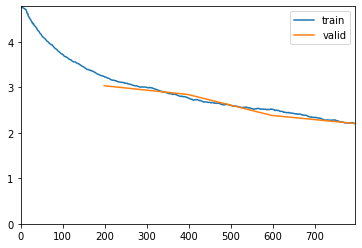

epoch,train_loss,valid_loss,accuracy,time
0,1.963855,1.989606,0.658405,00:23


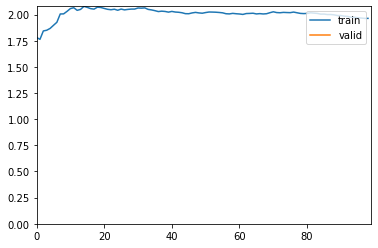

epoch,train_loss,valid_loss,accuracy,time
0,1.753210,1.862622,0.704203,00:25


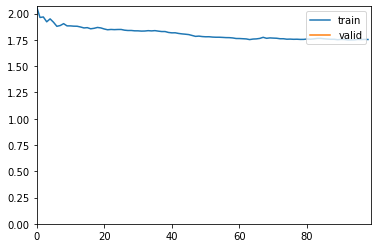


Run: 2


epoch,train_loss,valid_loss,accuracy,time
0,3.245588,3.044772,0.313578,00:42
1,2.829545,2.677407,0.441002,00:42
2,2.534817,2.411612,0.519666,00:42
3,2.278303,2.181743,0.588093,00:42


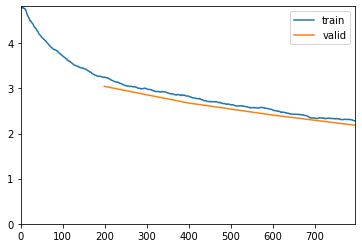

epoch,train_loss,valid_loss,accuracy,time
0,2.040611,2.029213,0.642511,00:23


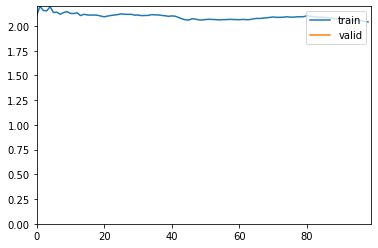

epoch,train_loss,valid_loss,accuracy,time
0,1.795828,1.903890,0.685345,00:23


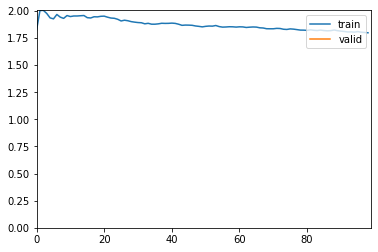


Run: 3


epoch,train_loss,valid_loss,accuracy,time
0,3.266710,3.009450,0.327317,00:42
1,2.747463,2.622939,0.450700,00:42
2,2.476855,2.378137,0.527209,00:42
3,2.218364,2.264288,0.579472,00:42


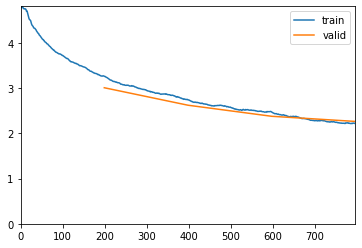

epoch,train_loss,valid_loss,accuracy,time
0,1.943171,1.988702,0.660291,00:23


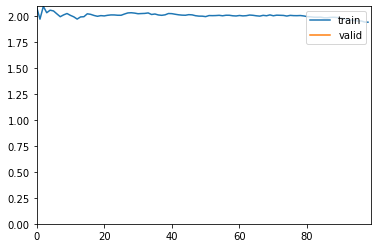

epoch,train_loss,valid_loss,accuracy,time
0,1.738082,1.868296,0.698815,00:23


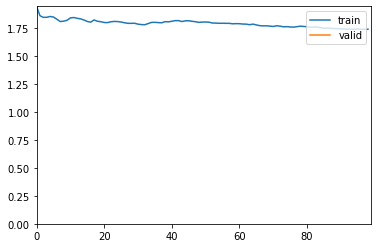


Run: 4


epoch,train_loss,valid_loss,accuracy,time
0,3.225353,3.041809,0.320582,00:42
1,2.786558,2.659796,0.441810,00:42
2,2.460174,2.421529,0.514009,00:42
3,2.168347,2.284477,0.552802,00:42


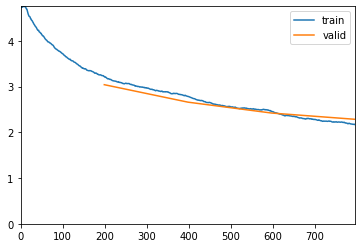

epoch,train_loss,valid_loss,accuracy,time
0,1.932480,1.962266,0.666487,00:23


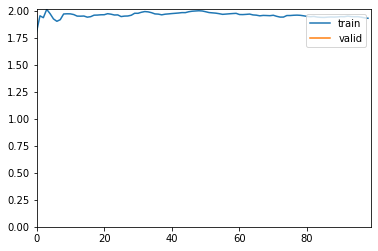

epoch,train_loss,valid_loss,accuracy,time
0,1.711203,1.838662,0.700970,00:23


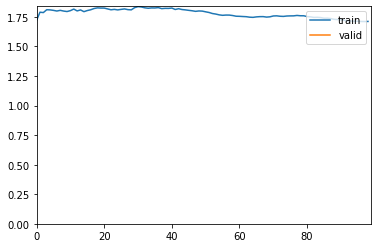


Run: 5


epoch,train_loss,valid_loss,accuracy,time
0,3.247756,3.043128,0.317080,00:42
1,2.828497,2.779683,0.413793,00:42
2,2.490148,2.476797,0.488416,00:42
3,2.242682,2.298038,0.550108,00:42


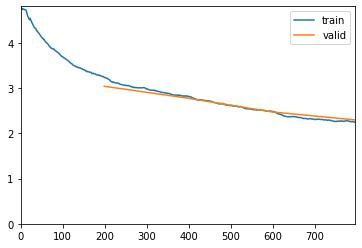

epoch,train_loss,valid_loss,accuracy,time
0,1.984502,1.984390,0.657328,00:23


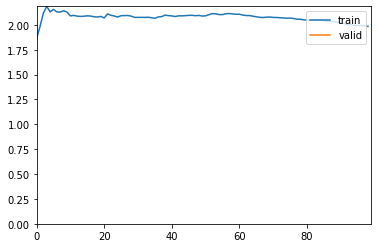

epoch,train_loss,valid_loss,accuracy,time
0,1.740982,1.876832,0.690194,00:23


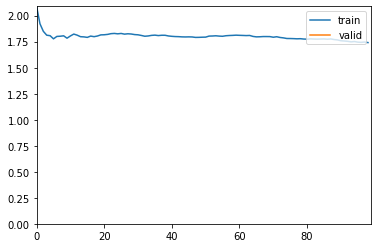

Average Val Acc: 69.59% ±0.79%
Average Val Loss: 1.87 ±0.02


In [24]:
acc_res, val_res, learn = do_train(runs=5,  num_ep=5, lr1=1e-2, lr2=1e-2)

# 9. FixRes 160/224, 4/1, Resize, no frozen augs, ffc/ffc

In [20]:
def get_dls(sz=224, bs=64, partial=False):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[*aug_transforms()])
    if partial: 
        partial_frac = 0.5
        partial_n = int(12753 * partial_frac)
        xtra_kwargs = [{}] * (2-1) #(self.n_subsets-1)
        dls = block.dataloaders('', bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs))
    else: dls = block.dataloaders('', bs=bs)
    return dls

In [21]:
def get_fzn_dls(sz=224, bs=64, partial=False):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[])
    if partial: 
        partial_frac = 0.5
        partial_n = int(12753 * partial_frac)
        xtra_kwargs = [{}] * (2-1) #(self.n_subsets-1)
        dls = block.dataloaders('', bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs))
    else: dls = block.dataloaders('', bs=bs)
    return dls

In [22]:
def do_train(runs=1,  num_ep=5, lr1=1e-2, lr2=2e-3):
    acc_res,val_res=[],[]
    stg_1_num_ep = 4
    cbs=[] #[ColorfulProgressCallback()],[WandbCallback()]
    for r in range(runs):
        print(f'Run: {r+1}')      
        # STG 1 - Fit 4e
        dls = get_dls(sz=160)
        m=xresnet50(pretrained=False, sa=True, act_cls=Mish, n_out=dls.c)
        loss_func=LabelSmoothingCrossEntropy()
        learn = Learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, 
                        splitter=xresnet50_splitter).to_fp16()
        learn.unfreeze()
        #learn.fit(stg_1_num_ep, lr1, cbs=ShowGraphCallback())
        learn.fit_flat_cos(stg_1_num_ep, lr1, cbs=ShowGraphCallback())
#         # STG 2 - PartialDL (0.5)
#         dls = get_dls(sz=192, partial=True)
#         learn.dls=dls
#         learn.fit_flat_cos(1, lr1, pct_start=0.75, cbs=ShowGraphCallback())
        
        # STG 3 - PartialDL (0.5)
        dls = get_fzn_dls(sz=224)
        learn.dls = dls
        learn.freeze()
        learn.fit_flat_cos(1, lr2, cbs=ShowGraphCallback())
        
        # LOG
        acc_res.append(learn.final_record[2])
        val_res.append(learn.final_record[1])
        # CLEAR MEM
        if r < runs-1:
            learn=None
            del learn
            torch.cuda.empty_cache()
            gc.collect()
            print('')
    
    if len(acc_res) > 1:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}% ±{(stdev(acc_res)*100):.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f} ±{stdev(val_res):.2f}')
    else:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f}')
    return acc_res, val_res, learn

Run: 1


epoch,train_loss,valid_loss,accuracy,time
0,3.258675,3.082825,0.298222,00:35
1,2.836555,3.102892,0.325970,00:33
2,2.506594,2.417673,0.511045,00:33
3,2.058797,1.998170,0.647360,00:33


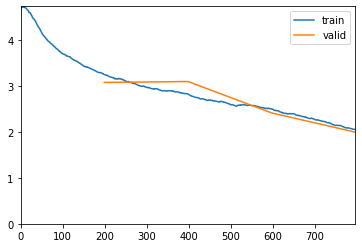

epoch,train_loss,valid_loss,accuracy,time
0,1.889346,1.912184,0.674030,00:44


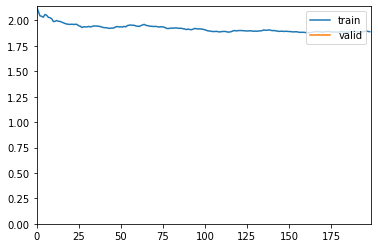


Run: 2


epoch,train_loss,valid_loss,accuracy,time
0,3.238849,3.133164,0.287716,00:33
1,2.748947,2.694111,0.448545,00:33
2,2.503372,2.495045,0.488685,00:34
3,2.008178,1.969085,0.668373,00:34


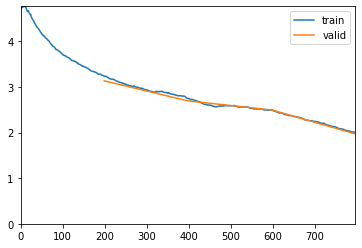

epoch,train_loss,valid_loss,accuracy,time
0,1.837304,1.889336,0.688039,00:42


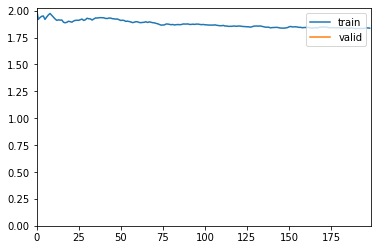


Run: 3


epoch,train_loss,valid_loss,accuracy,time
0,3.257375,3.203007,0.316541,00:33
1,2.801430,2.625870,0.439116,00:33
2,2.509704,2.359048,0.539062,00:34
3,2.037675,1.978058,0.659483,00:34


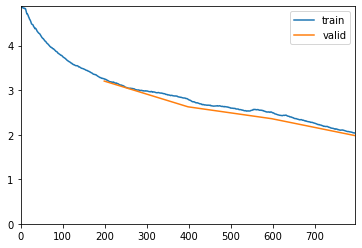

epoch,train_loss,valid_loss,accuracy,time
0,1.856485,1.904824,0.682381,00:42


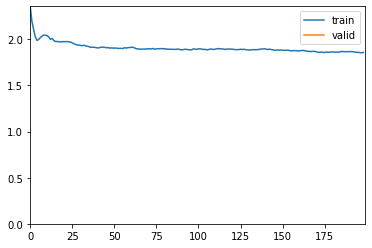

Average Val Acc: 68.15% ±0.70%
Average Val Loss: 1.90 ±0.01


In [23]:
# 4/1, ffc/ffc
acc_res, val_res, learn = do_train(runs=3,  num_ep=5, lr1=1e-2, lr2=1e-2)

# 10. FixRes 160/224, 4.5/0.5, Resize, no frozen augs, fit, ffc, ffc

In [19]:
def get_dls(sz=224, bs=64, partial=False):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[*aug_transforms()])
    if partial: 
        partial_frac = 0.5
        partial_n = int(12753 * partial_frac)
        xtra_kwargs = [{}] * (2-1) #(self.n_subsets-1)
        dls = block.dataloaders('', bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs))
    else: dls = block.dataloaders('', bs=bs)
    return dls

In [20]:
def get_fzn_dls(sz=224, bs=64, partial=False):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[])
    if partial: 
        partial_frac = 0.5
        partial_n = int(12753 * partial_frac)
        xtra_kwargs = [{}] * (2-1) #(self.n_subsets-1)
        dls = block.dataloaders('', bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs))
    else: dls = block.dataloaders('', bs=bs)
    return dls

In [21]:
def do_train(runs=1,  num_ep=5, lr1=1e-2, lr2=2e-3):
    acc_res,val_res=[],[]
    stg_1_num_ep = 4
    cbs=[] #[ColorfulProgressCallback()],[WandbCallback()]
    for r in range(runs):
        print(f'Run: {r+1}')      
        # STG 1 - Fit 4e
        dls = get_dls(sz=160)

        m=xresnet50(pretrained=False, sa=True, act_cls=Mish, n_out=dls.c)
        loss_func=LabelSmoothingCrossEntropy()

        learn = Learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, 
                        splitter=xresnet50_splitter).to_fp16()
        learn.unfreeze()
        learn.fit(stg_1_num_ep, lr1, cbs=ShowGraphCallback())
        
        # STG 2 - PartialDL (0.5)
        dls = get_dls(sz=160, partial=True)
        learn.dls=dls
        learn.fit_flat_cos(1, lr1, cbs=ShowGraphCallback())
        
        # STG 3 - PartialDL (0.5)
        dls = get_fzn_dls(sz=224, partial=True)
        learn.dls = dls
        learn.freeze()
        learn.fit_flat_cos(1, lr2, cbs=ShowGraphCallback())
        
        # LOG
        acc_res.append(learn.final_record[2])
        val_res.append(learn.final_record[1])
        # CLEAR MEM
        if r < runs-1:
            learn=None
            del learn
            torch.cuda.empty_cache()
            gc.collect()
            print('')
    
    if len(acc_res) > 1:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}% ±{(stdev(acc_res)*100):.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f} ±{stdev(val_res):.2f}')
    else:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f}')
    return acc_res, val_res, learn

Run: 1


epoch,train_loss,valid_loss,accuracy,time
0,3.277420,3.133214,0.281789,00:35
1,2.777627,2.766561,0.430765,00:33
2,2.503653,2.367814,0.521013,00:33
3,2.192137,2.213557,0.564655,00:33


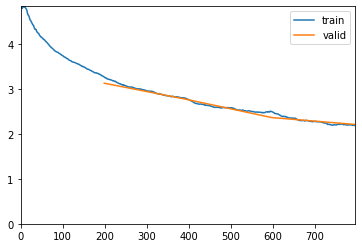

epoch,train_loss,valid_loss,accuracy,time
0,1.959840,1.982035,0.660830,00:18


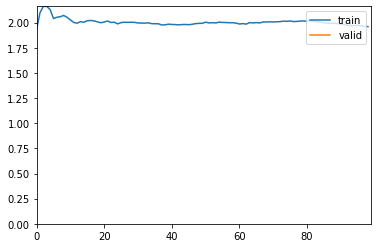

epoch,train_loss,valid_loss,accuracy,time
0,1.749055,1.872611,0.696929,00:25


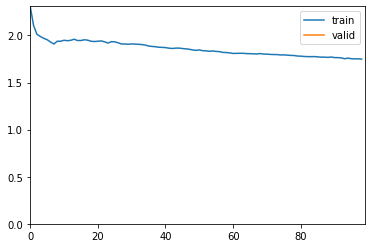


Run: 2


epoch,train_loss,valid_loss,accuracy,time
0,3.305564,3.133492,0.297144,00:33
1,2.861728,2.639671,0.434537,00:33
2,2.578712,2.469070,0.498384,00:33
3,2.260275,2.313138,0.548491,00:33


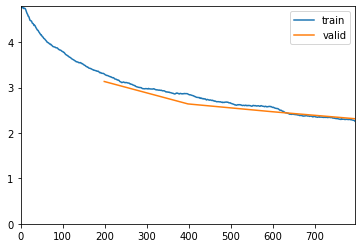

epoch,train_loss,valid_loss,accuracy,time
0,2.045054,2.071945,0.628233,00:18


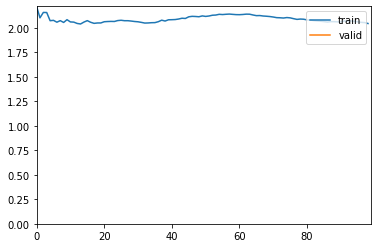

epoch,train_loss,valid_loss,accuracy,time
0,1.849034,1.936859,0.672683,00:23


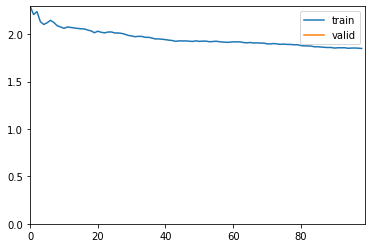


Run: 3


epoch,train_loss,valid_loss,accuracy,time
0,3.298121,3.074381,0.309267,00:33
1,2.786367,2.685842,0.444504,00:33
2,2.423403,2.489669,0.512123,00:33
3,2.222938,2.347944,0.536099,00:34


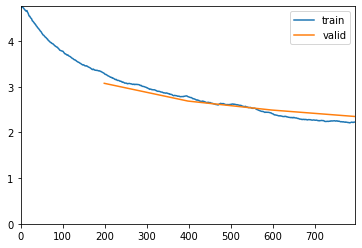

epoch,train_loss,valid_loss,accuracy,time
0,1.952848,2.020677,0.659213,00:18


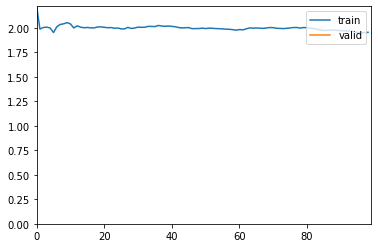

epoch,train_loss,valid_loss,accuracy,time
0,1.781991,1.862671,0.695851,00:23


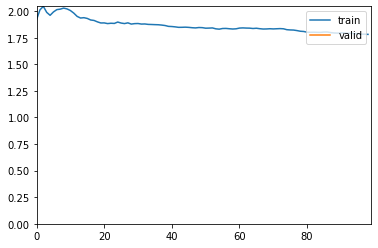


Run: 4


epoch,train_loss,valid_loss,accuracy,time
0,3.242991,3.038812,0.321659,00:33
1,2.789494,2.762446,0.406789,00:33
2,2.439070,2.346001,0.547144,00:33
3,2.178133,2.386781,0.521552,00:34


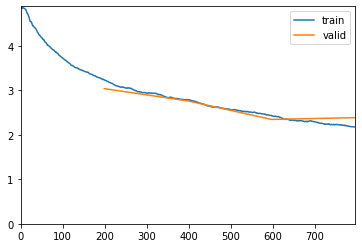

epoch,train_loss,valid_loss,accuracy,time
0,1.958225,2.004936,0.654634,00:18


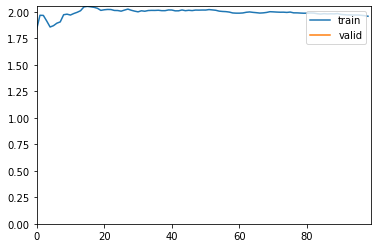

epoch,train_loss,valid_loss,accuracy,time
0,1.758296,1.859384,0.698815,00:23


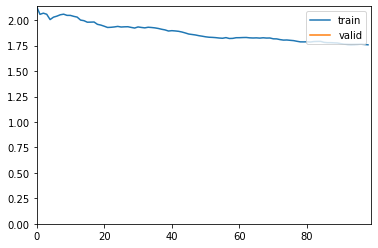


Run: 5


epoch,train_loss,valid_loss,accuracy,time
0,3.231653,3.179149,0.288524,00:33
1,2.769216,2.583153,0.459052,00:33
2,2.454578,2.391269,0.543642,00:34
3,2.206714,2.266346,0.552263,00:33


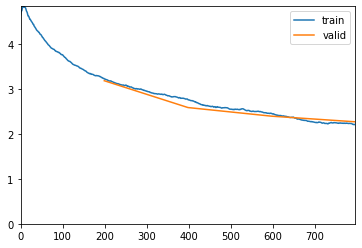

epoch,train_loss,valid_loss,accuracy,time
0,1.931674,1.969545,0.661907,00:18


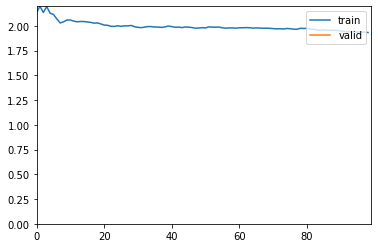

epoch,train_loss,valid_loss,accuracy,time
0,1.775653,1.858638,0.703664,00:23


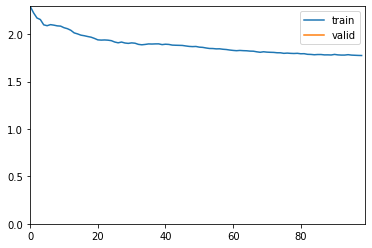

Average Val Acc: 69.36% ±1.21%
Average Val Loss: 1.88 ±0.03


In [22]:
acc_res, val_res, learn = do_train(runs=5,  num_ep=5, lr1=1e-2, lr2=1e-2)

# 11. FixRes 160/224, 4.5/0.5, Resize, no frozen augs, *ffc*, ffc, ffc

In [19]:
def get_dls(sz=224, bs=64, partial=False):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[*aug_transforms()])
    if partial: 
        partial_frac = 0.5
        partial_n = int(12753 * partial_frac)
        xtra_kwargs = [{}] * (2-1) #(self.n_subsets-1)
        dls = block.dataloaders('', bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs))
    else: dls = block.dataloaders('', bs=bs)
    return dls

In [20]:
def get_fzn_dls(sz=224, bs=64, partial=False):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[])
    if partial: 
        partial_frac = 0.5
        partial_n = int(12753 * partial_frac)
        xtra_kwargs = [{}] * (2-1) #(self.n_subsets-1)
        dls = block.dataloaders('', bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs))
    else: dls = block.dataloaders('', bs=bs)
    return dls

In [21]:
def do_train(runs=1,  num_ep=5, lr1=1e-2, lr2=2e-3):
    acc_res,val_res=[],[]
    stg_1_num_ep = 4
    cbs=[] #[ColorfulProgressCallback()],[WandbCallback()]
    for r in range(runs):
        print(f'Run: {r+1}')      
        # STG 1 - Fit 4e
        dls = get_dls(sz=160)

        m=xresnet50(pretrained=False, sa=True, act_cls=Mish, n_out=dls.c)
        loss_func=LabelSmoothingCrossEntropy()

        learn = Learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, 
                        splitter=xresnet50_splitter).to_fp16()
        learn.unfreeze()
        learn.fit_flat_cos(stg_1_num_ep, lr1, cbs=ShowGraphCallback())
        
        # STG 2 - PartialDL (0.5)
        dls = get_dls(sz=160, partial=True)
        learn.dls=dls
        learn.fit_flat_cos(1, lr1, cbs=ShowGraphCallback())
        
        # STG 3 - PartialDL (0.5)
        dls = get_fzn_dls(sz=224, partial=True)
        learn.dls = dls
        learn.freeze()
        learn.fit_flat_cos(1, lr2, cbs=ShowGraphCallback())
        
        # LOG
        acc_res.append(learn.final_record[2])
        val_res.append(learn.final_record[1])
        # CLEAR MEM
        if r < runs-1:
            learn=None
            del learn
            torch.cuda.empty_cache()
            gc.collect()
            print('')
    
    if len(acc_res) > 1:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}% ±{(stdev(acc_res)*100):.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f} ±{stdev(val_res):.2f}')
    else:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f}')
    return acc_res, val_res, learn

Run: 1


epoch,train_loss,valid_loss,accuracy,time
0,3.288601,3.029727,0.311153,00:35
1,2.796444,2.712137,0.427263,00:33
2,2.484877,2.458365,0.507543,00:33
3,2.021326,1.951401,0.670797,00:33


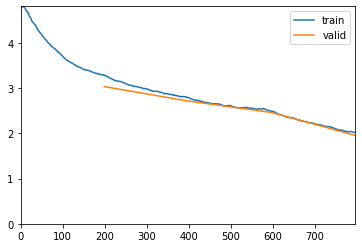

epoch,train_loss,valid_loss,accuracy,time
0,2.027781,2.017687,0.649785,00:18


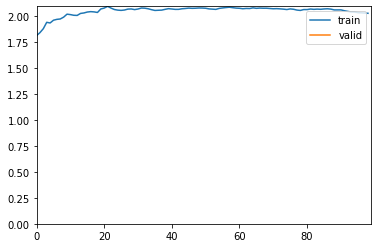

epoch,train_loss,valid_loss,accuracy,time
0,1.834821,1.892454,0.693696,00:25


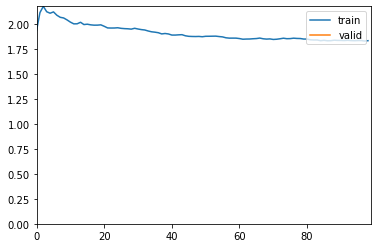


Run: 2


epoch,train_loss,valid_loss,accuracy,time
0,3.268730,3.035752,0.326509,00:33
1,2.810893,2.602025,0.455550,00:34
2,2.511447,2.447201,0.509429,00:34
3,2.036481,2.010740,0.648438,00:34


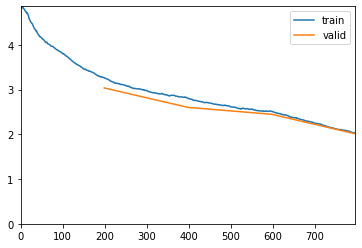

epoch,train_loss,valid_loss,accuracy,time
0,2.054006,2.097009,0.626616,00:18


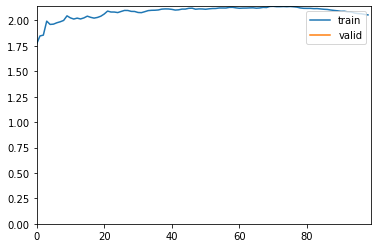

epoch,train_loss,valid_loss,accuracy,time
0,1.834482,1.948807,0.657328,00:23


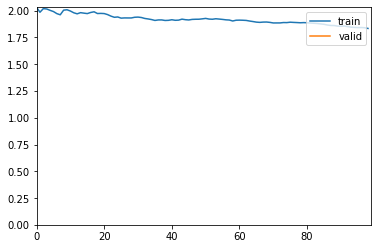


Run: 3


epoch,train_loss,valid_loss,accuracy,time
0,3.263527,3.204103,0.271013,00:33
1,2.836369,2.673599,0.421875,00:34
2,2.488914,2.402690,0.524785,00:34
3,2.056259,1.993898,0.651670,00:34


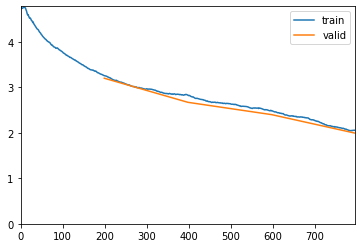

epoch,train_loss,valid_loss,accuracy,time
0,2.082417,2.080637,0.622037,00:18


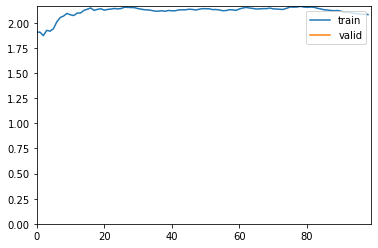

epoch,train_loss,valid_loss,accuracy,time
0,1.847542,1.933042,0.675108,00:23


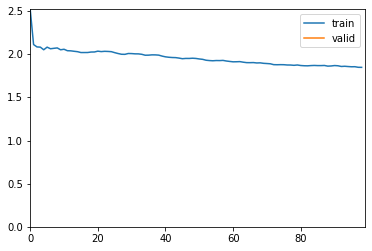


Run: 4


epoch,train_loss,valid_loss,accuracy,time
0,3.232406,3.008006,0.324623,00:33
1,2.746794,2.879587,0.381735,00:34
2,2.407356,2.443397,0.508621,00:34
3,1.975945,1.961618,0.662985,00:34


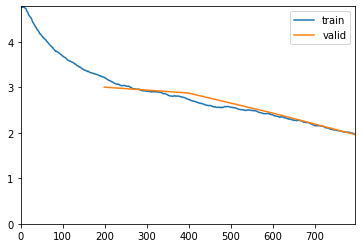

epoch,train_loss,valid_loss,accuracy,time
0,2.036982,2.062658,0.627694,00:18


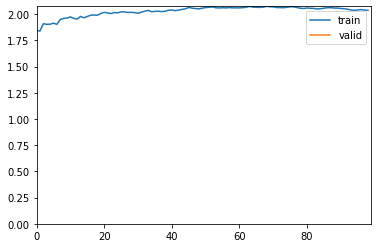

epoch,train_loss,valid_loss,accuracy,time
0,1.800279,1.919722,0.675647,00:23


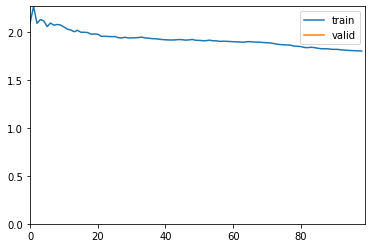


Run: 5


epoch,train_loss,valid_loss,accuracy,time
0,3.278511,2.996821,0.332705,00:33
1,2.804038,2.708312,0.419450,00:33
2,2.485735,2.395807,0.522629,00:34
3,2.013754,1.973747,0.655172,00:34


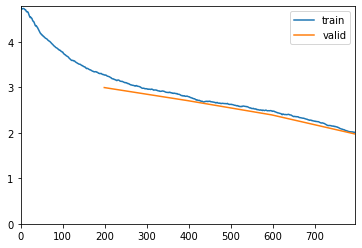

epoch,train_loss,valid_loss,accuracy,time
0,2.084215,2.050704,0.627425,00:18


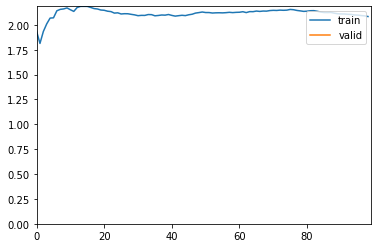

epoch,train_loss,valid_loss,accuracy,time
0,1.845731,1.925273,0.676994,00:23


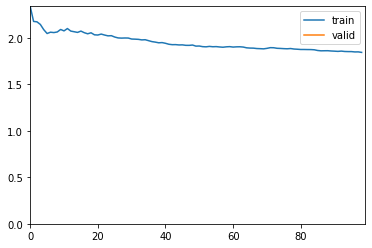

Average Val Acc: 67.58% ±1.29%
Average Val Loss: 1.92 ±0.02


In [22]:
acc_res, val_res, learn = do_train(runs=5,  num_ep=5, lr1=1e-2, lr2=1e-2)

# 12. FixRes 160/224, 4.5/0.5, Resize, no frozen augs, *ffc*, ffc (lr1/15), ffc

In [21]:
def get_dls(sz=224, bs=64, partial=False):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[*aug_transforms()])
    if partial: 
        partial_frac = 0.5
        partial_n = int(12753 * partial_frac)
        xtra_kwargs = [{}] * (2-1) #(self.n_subsets-1)
        dls = block.dataloaders('', bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs))
    else: dls = block.dataloaders('', bs=bs)
    return dls

In [22]:
def get_fzn_dls(sz=224, bs=64, partial=False):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[])
    if partial: 
        partial_frac = 0.5
        partial_n = int(12753 * partial_frac)
        xtra_kwargs = [{}] * (2-1) #(self.n_subsets-1)
        dls = block.dataloaders('', bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs))
    else: dls = block.dataloaders('', bs=bs)
    return dls

In [23]:
def do_train(runs=1,  num_ep=5, lr1=1e-2, lr2=2e-3):
    acc_res,val_res=[],[]
    stg_1_num_ep = 4
    cbs=[] #[ColorfulProgressCallback()],[WandbCallback()]
    for r in range(runs):
        print(f'Run: {r+1}')      
        # STG 1 - Fit 4e
        dls = get_dls(sz=160)
        m=xresnet50(pretrained=False, sa=True, act_cls=Mish, n_out=dls.c)
        loss_func=LabelSmoothingCrossEntropy()
        learn = Learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, 
                        splitter=xresnet50_splitter).to_fp16()
        learn.unfreeze()
        learn.fit_flat_cos(stg_1_num_ep, lr1, cbs=ShowGraphCallback())
        
        # STG 2 - PartialDL (0.5)
        dls = get_dls(sz=160, partial=True)
        learn.dls=dls
        learn.fit_flat_cos(1, lr1/15, pct_start=0.5, cbs=ShowGraphCallback())
        
        # STG 3 - PartialDL (0.5)
        dls = get_fzn_dls(sz=224, partial=True)
        learn.dls = dls
        learn.freeze()
        learn.fit_flat_cos(1, lr2, cbs=ShowGraphCallback())
        
        # LOG
        acc_res.append(learn.final_record[2])
        val_res.append(learn.final_record[1])
        # CLEAR MEM
        if r < runs-1:
            learn=None
            del learn
            torch.cuda.empty_cache()
            gc.collect()
            print('')
    
    if len(acc_res) > 1:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}% ±{(stdev(acc_res)*100):.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f} ±{stdev(val_res):.2f}')
    else:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f}')
    return acc_res, val_res, learn

Run: 1


epoch,train_loss,valid_loss,accuracy,time
0,3.285593,3.168375,0.287985,00:35
1,2.835734,2.598113,0.467134,00:33
2,2.501730,2.425099,0.511584,00:33
3,2.049880,1.992966,0.651401,00:33


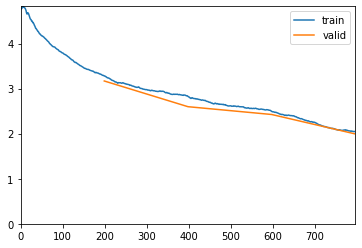

epoch,train_loss,valid_loss,accuracy,time
0,1.812381,1.961358,0.667565,00:18


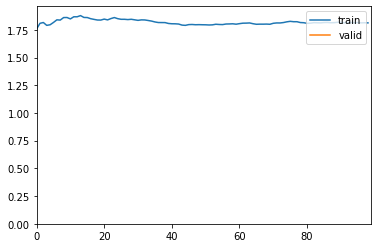

epoch,train_loss,valid_loss,accuracy,time
0,1.848581,1.958097,0.662177,00:25


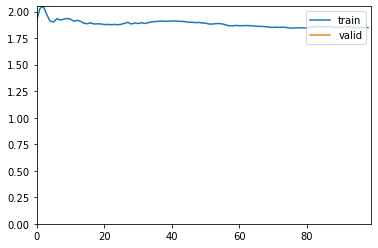


Run: 2


epoch,train_loss,valid_loss,accuracy,time
0,3.259942,3.008255,0.321121,00:33
1,2.830204,2.648414,0.442080,00:34
2,2.505342,2.337682,0.534752,00:34
3,2.038255,1.975609,0.658405,00:34


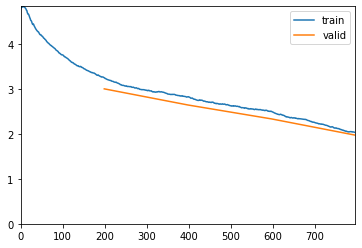

epoch,train_loss,valid_loss,accuracy,time
0,1.815913,1.951351,0.667295,00:18


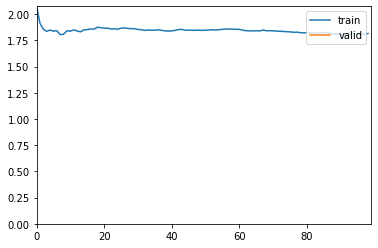

epoch,train_loss,valid_loss,accuracy,time
0,1.839870,1.949969,0.670528,00:23


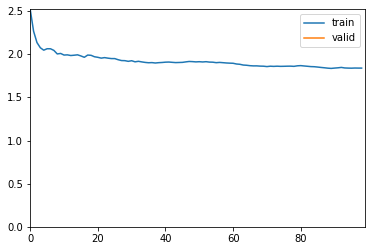


Run: 3


epoch,train_loss,valid_loss,accuracy,time
0,3.294779,3.488328,0.247575,00:33
1,2.842278,2.728398,0.414332,00:34
2,2.510906,2.420964,0.513739,00:34
3,2.057569,2.004126,0.654364,00:34


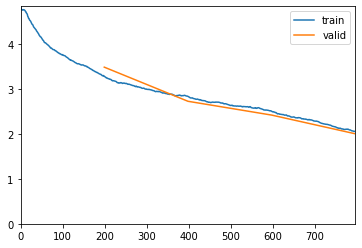

epoch,train_loss,valid_loss,accuracy,time
0,1.847478,1.969609,0.666756,00:18


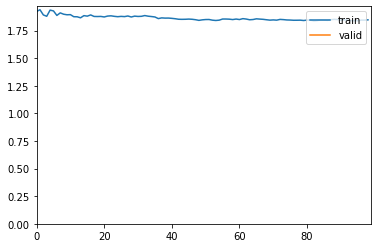

epoch,train_loss,valid_loss,accuracy,time
0,1.866965,1.959680,0.665410,00:23


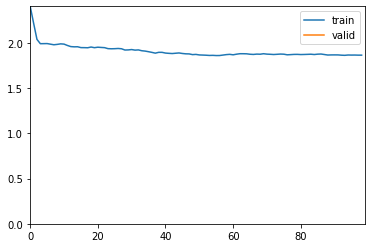


Run: 4


epoch,train_loss,valid_loss,accuracy,time
0,3.254153,3.035958,0.310075,00:34
1,2.813239,2.759974,0.416487,00:34
2,2.506011,2.469341,0.491649,00:34
3,2.034282,1.983711,0.661369,00:34


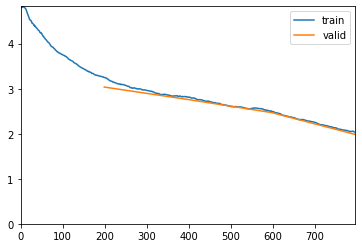

epoch,train_loss,valid_loss,accuracy,time
0,1.837640,1.949342,0.666218,00:18


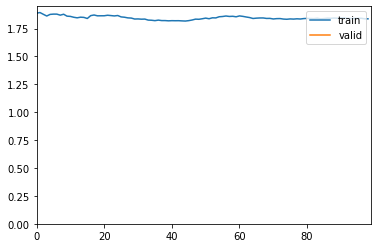

epoch,train_loss,valid_loss,accuracy,time
0,1.811392,1.944860,0.678879,00:23


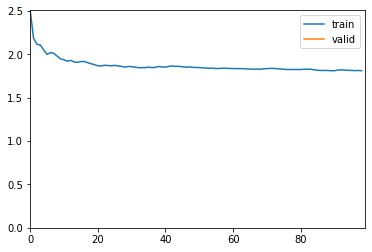


Run: 5


epoch,train_loss,valid_loss,accuracy,time
0,3.270156,3.018330,0.329741,00:34
1,2.765094,2.841301,0.415409,00:34
2,2.478790,2.436466,0.507004,00:34
3,2.032566,1.964112,0.663254,00:34


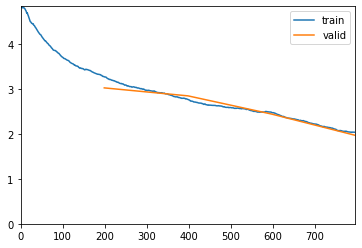

epoch,train_loss,valid_loss,accuracy,time
0,1.813234,1.934251,0.677802,00:19


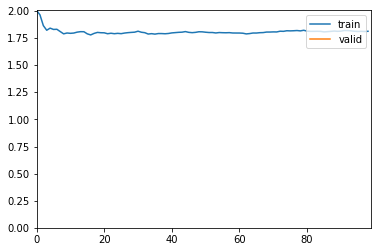

epoch,train_loss,valid_loss,accuracy,time
0,1.785576,1.929711,0.678071,00:23


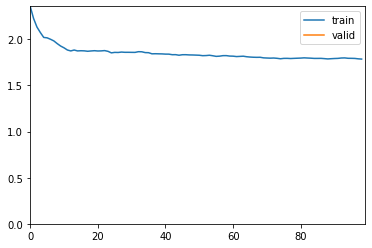

Average Val Acc: 67.10% ±0.74%
Average Val Loss: 1.95 ±0.01


In [24]:
acc_res, val_res, learn = do_train(runs=5,  num_ep=5, lr1=1e-2, lr2=1e-2)

# 13. FixRes 160/224, 4.5/0.5, Resize, no frozen augs, *ffc*, ffc (lr1/15), ffc Tune lrs

In [20]:
def get_dls(sz=224, bs=64, partial=False):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[*aug_transforms()])
    if partial: 
        partial_frac = 0.5
        partial_n = int(12753 * partial_frac)
        xtra_kwargs = [{}] * (2-1) #(self.n_subsets-1)
        dls = block.dataloaders('', bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs))
    else: dls = block.dataloaders('', bs=bs)
    return dls

In [21]:
def get_fzn_dls(sz=224, bs=64, partial=False):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[])
    if partial: 
        partial_frac = 0.5
        partial_n = int(12753 * partial_frac)
        xtra_kwargs = [{}] * (2-1) #(self.n_subsets-1)
        dls = block.dataloaders('', bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs))
    else: dls = block.dataloaders('', bs=bs)
    return dls

epoch,train_loss,valid_loss,accuracy,time
0,3.260121,3.078811,0.312500,00:35
1,2.797175,2.764843,0.423761,00:33
2,2.452271,2.329971,0.546067,00:33
3,1.989504,1.929758,0.675647,00:33


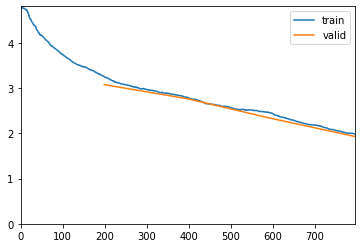

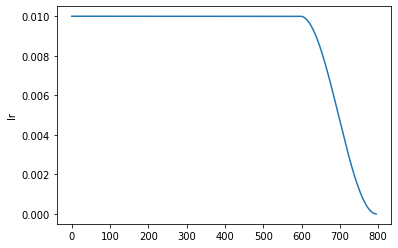

In [22]:
stg_1_num_ep = 4
dls = get_dls(sz=160)
m=xresnet50(pretrained=False, sa=True, act_cls=Mish, n_out=dls.c)
loss_func=LabelSmoothingCrossEntropy()
learn = Learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, 
                splitter=xresnet50_splitter).to_fp16()
learn.unfreeze()
learn.fit_flat_cos(stg_1_num_ep, 1e-2, cbs=ShowGraphCallback())
learn.recorder.plot_sched()

epoch,train_loss,valid_loss,accuracy,time
0,1.802937,1.927047,0.676994,00:18


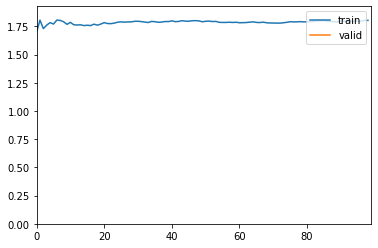

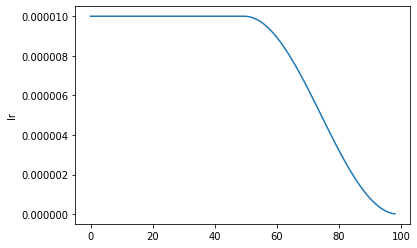

In [23]:
# STG 2 - PartialDL (0.5)
dls = get_dls(sz=160, partial=True)
learn.dls=dls
learn.fit_flat_cos(1, 1e-5, pct_start=0.5, cbs=ShowGraphCallback())
learn.recorder.plot_sched()

SuggestedLRs(lr_min=0.13182567358016967, lr_steep=1.0964782238006592)

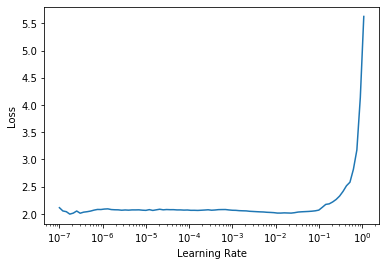

In [24]:
# STG 3 - PartialDL (0.5)
dls = get_fzn_dls(sz=224, partial=True)
learn.dls = dls
learn.freeze()

learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,2.003630,2.077526,0.642780,00:23


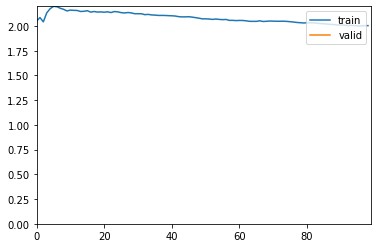

In [25]:
learn.fit_flat_cos(1, 1e-4, cbs=ShowGraphCallback())

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.3019951581954956)

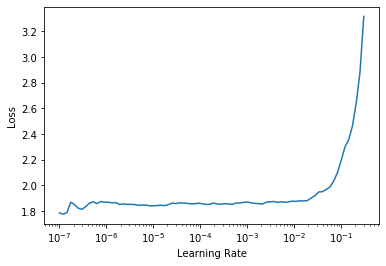

In [29]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.856841,1.968942,0.669181,00:18


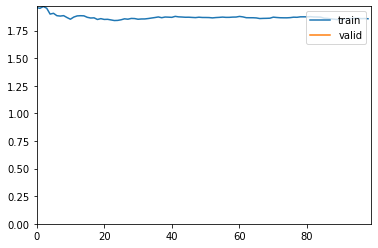

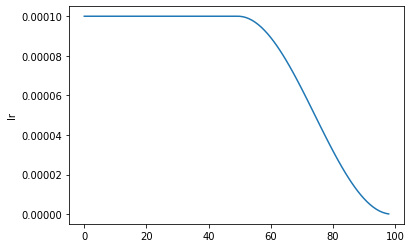

In [30]:
# STG 2 - PartialDL (0.5)
dls = get_dls(sz=160, partial=True)
learn.dls=dls
learn.fit_flat_cos(1, 1e-4, pct_start=0.5, cbs=ShowGraphCallback())
learn.recorder.plot_sched()

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.3019951581954956)

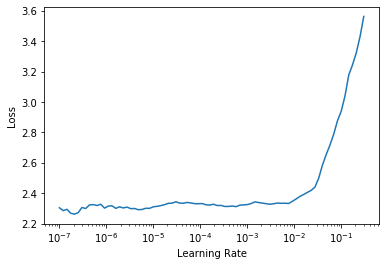

In [31]:
# STG 3 - PartialDL (0.5)
dls = get_fzn_dls(sz=224, partial=True)
learn.dls = dls
learn.freeze()

learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,4.835774,5.344570,0.146013,00:23


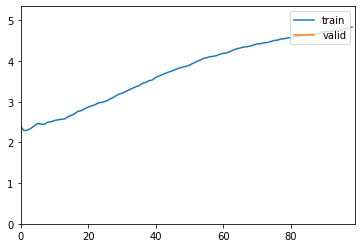

In [27]:
learn.fit_flat_cos(1, 3e-2, cbs=ShowGraphCallback())

In [23]:
def do_train(runs=1,  num_ep=5, lr1=1e-2, lr2=2e-3):
    acc_res,val_res=[],[]
    stg_1_num_ep = 4
    cbs=[] #[ColorfulProgressCallback()],[WandbCallback()]
    for r in range(runs):
        print(f'Run: {r+1}')      
        # STG 1 - Fit 4e
        dls = get_dls(sz=160)
        m=xresnet50(pretrained=False, sa=True, act_cls=Mish, n_out=dls.c)
        loss_func=LabelSmoothingCrossEntropy()
        learn = Learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, 
                        splitter=xresnet50_splitter).to_fp16()
        learn.unfreeze()
        learn.fit_flat_cos(stg_1_num_ep, lr1, cbs=ShowGraphCallback())
        
        # STG 2 - PartialDL (0.5)
        dls = get_dls(sz=160, partial=True)
        learn.dls=dls
        learn.fit_flat_cos(1, lr1/15, pct_start=0.5, cbs=ShowGraphCallback())
        
        # STG 3 - PartialDL (0.5)
        dls = get_fzn_dls(sz=224, partial=True)
        learn.dls = dls
        learn.freeze()
        learn.fit_flat_cos(1, lr2, cbs=ShowGraphCallback())
        
        # LOG
        acc_res.append(learn.final_record[2])
        val_res.append(learn.final_record[1])
        # CLEAR MEM
        if r < runs-1:
            learn=None
            del learn
            torch.cuda.empty_cache()
            gc.collect()
            print('')
    
    if len(acc_res) > 1:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}% ±{(stdev(acc_res)*100):.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f} ±{stdev(val_res):.2f}')
    else:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f}')
    return acc_res, val_res, learn

Run: 1


epoch,train_loss,valid_loss,accuracy,time
0,3.285593,3.168375,0.287985,00:35
1,2.835734,2.598113,0.467134,00:33
2,2.501730,2.425099,0.511584,00:33
3,2.049880,1.992966,0.651401,00:33


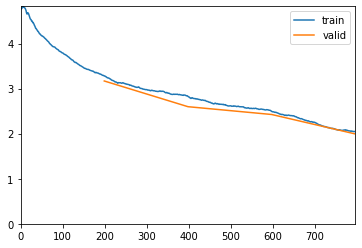

epoch,train_loss,valid_loss,accuracy,time
0,1.812381,1.961358,0.667565,00:18


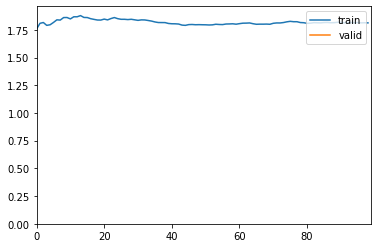

epoch,train_loss,valid_loss,accuracy,time
0,1.848581,1.958097,0.662177,00:25


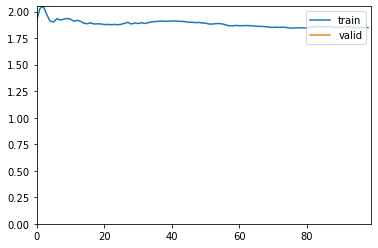


Run: 2


epoch,train_loss,valid_loss,accuracy,time
0,3.259942,3.008255,0.321121,00:33
1,2.830204,2.648414,0.442080,00:34
2,2.505342,2.337682,0.534752,00:34
3,2.038255,1.975609,0.658405,00:34


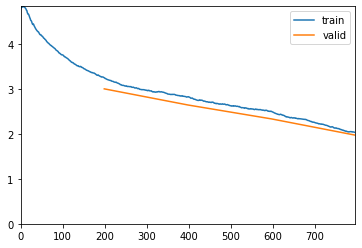

epoch,train_loss,valid_loss,accuracy,time
0,1.815913,1.951351,0.667295,00:18


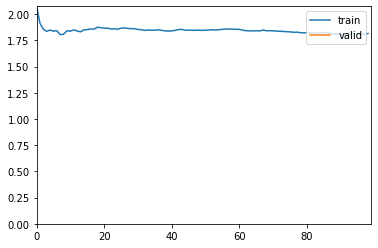

epoch,train_loss,valid_loss,accuracy,time
0,1.839870,1.949969,0.670528,00:23


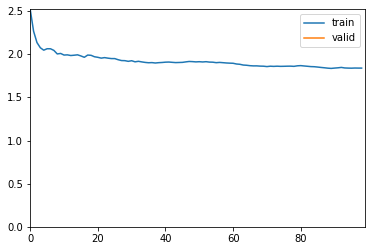


Run: 3


epoch,train_loss,valid_loss,accuracy,time
0,3.294779,3.488328,0.247575,00:33
1,2.842278,2.728398,0.414332,00:34
2,2.510906,2.420964,0.513739,00:34
3,2.057569,2.004126,0.654364,00:34


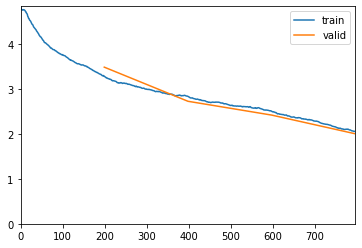

epoch,train_loss,valid_loss,accuracy,time
0,1.847478,1.969609,0.666756,00:18


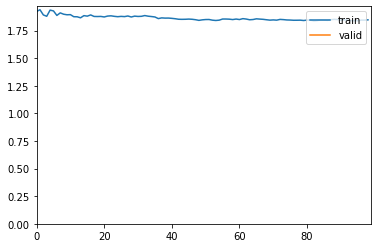

epoch,train_loss,valid_loss,accuracy,time
0,1.866965,1.959680,0.665410,00:23


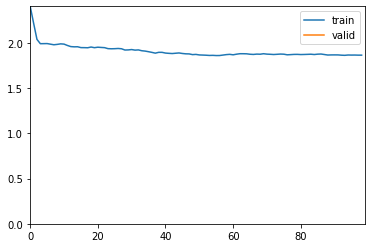


Run: 4


epoch,train_loss,valid_loss,accuracy,time
0,3.254153,3.035958,0.310075,00:34


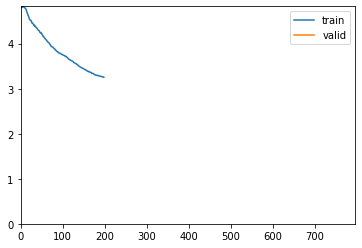

In [ ]:
acc_res, val_res, learn = do_train(runs=5,  num_ep=5, lr1=1e-2, lr2=1e-2)

# 14. FixRes 160/224, 4.5/0.5, Resize, fastai head, no frozen augs, fit, ffc, ffc

In [19]:
def get_dls(sz=224, bs=64, partial=False):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[*aug_transforms()])
    if partial: 
        partial_frac = 0.5
        partial_n = int(12753 * partial_frac)
        xtra_kwargs = [{}] * (2-1) #(self.n_subsets-1)
        dls = block.dataloaders('', bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs))
    else: dls = block.dataloaders('', bs=bs)
    return dls

In [20]:
def get_fzn_dls(sz=224, bs=64, partial=False):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[])
    if partial: 
        partial_frac = 0.5
        partial_n = int(12753 * partial_frac)
        xtra_kwargs = [{}] * (2-1) #(self.n_subsets-1)
        dls = block.dataloaders('', bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs))
    else: dls = block.dataloaders('', bs=bs)
    return dls

In [21]:
def do_train(runs=1,  num_ep=5, lr1=1e-2, lr2=2e-3):
    acc_res,val_res=[],[]
    stg_1_num_ep = 4
    cbs=[] #[ColorfulProgressCallback()],[WandbCallback()]
    for r in range(runs):
        print(f'Run: {r+1}')      
        # STG 1 - Fit 4e
        dls = get_dls(sz=160)

        m=xresnet50(pretrained=False, sa=True, act_cls=Mish, n_out=dls.c)
        loss_func=LabelSmoothingCrossEntropy()

#         learn = Learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, 
#                         splitter=xresnet50_splitter).to_fp16()
        
        m=partial(xresnet50, pretrained=False, sa=True, act_cls=Mish, n_out=dls.c)
        learn = cnn_learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, pretrained=False).to_fp16() #
        
        learn.unfreeze()
        learn.fit(stg_1_num_ep, lr1, cbs=ShowGraphCallback())
        
        # STG 2 - PartialDL (0.5)
        dls = get_dls(sz=160, partial=True)
        learn.dls=dls
        learn.fit_flat_cos(1, lr1, cbs=ShowGraphCallback())
        
        # STG 3 - PartialDL (0.5)
        dls = get_fzn_dls(sz=224, partial=True)
        learn.dls = dls
        learn.freeze()
        learn.fit_flat_cos(1, lr2, cbs=ShowGraphCallback())
        
        # LOG
        acc_res.append(learn.final_record[2])
        val_res.append(learn.final_record[1])
        # CLEAR MEM
        if r < runs-1:
            learn=None
            del learn
            torch.cuda.empty_cache()
            gc.collect()
            print('')
    
    if len(acc_res) > 1:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}% ±{(stdev(acc_res)*100):.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f} ±{stdev(val_res):.2f}')
    else:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f}')
    return acc_res, val_res, learn

epoch,train_loss,valid_loss,accuracy,time
0,4.022679,3.409423,0.263200,00:32
1,3.422161,2.967174,0.347791,00:33
2,3.009409,2.707044,0.418373,00:33
3,2.492334,2.237118,0.557381,00:33


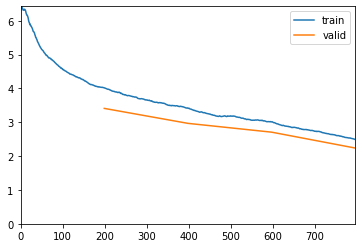

In [55]:
learn.fit_flat_cos(4, 1e-2, cbs=ShowGraphCallback())

epoch,train_loss,valid_loss,accuracy,time
0,2.309802,2.108111,0.601293,00:42


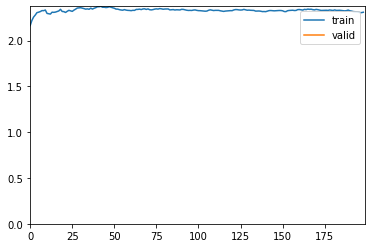

In [56]:
#FROZEN
dls = get_fzn_dls(sz=224)
learn.dls = dls
learn.freeze()
learn.fit_flat_cos(1, 1e-2, cbs=ShowGraphCallback())

# 15. Baseline reference + RRC (scale 0.7), no zoom

In [57]:
def get_dls(sz=224, bs=64, partial=False):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[RandomResizedCrop(sz)],
                      batch_tfms=[*aug_transforms(max_zoom=1.0)])
    if partial: 
        partial_frac = 0.5
        partial_n = int(12753 * partial_frac)
        xtra_kwargs = [{}] * (2-1) #(self.n_subsets-1)
        dls = block.dataloaders('', bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs))
    else: dls = block.dataloaders('', bs=bs)
    return dls

In [58]:
def do_train(runs=1,  num_ep=5, lr1=1e-2, lr2=2e-3):
    acc_res,val_res=[],[]
    #stg_1_num_ep = 4
    cbs=[] #[ColorfulProgressCallback()],[WandbCallback()]
    for r in range(runs):
        print(f'Run: {r+1}')      
        # STG 1 - Fit 5e
        dls = get_dls(sz=224)
        m=xresnet50(pretrained=False, sa=True, act_cls=Mish, n_out=dls.c)
        loss_func=LabelSmoothingCrossEntropy()
        learn = Learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, 
                        splitter=xresnet50_splitter).to_fp16()
        learn.unfreeze()
        learn.fit_flat_cos(num_ep, lr1, cbs=ShowGraphCallback())
        
        # LOG
        acc_res.append(learn.final_record[2])
        val_res.append(learn.final_record[1])
        # CLEAR MEM
        if r < runs-1:
            learn=None
            del learn
            torch.cuda.empty_cache()
            gc.collect()
            print('')
    
    if len(acc_res) > 1:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}% ±{(stdev(acc_res)*100):.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f} ±{stdev(val_res):.2f}')
    else:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f}')
    return acc_res, val_res, learn

Run: 1


epoch,train_loss,valid_loss,accuracy,time
0,3.390677,3.104249,0.299300,00:53
1,3.042963,2.854677,0.360183,00:53
2,2.803568,2.600215,0.438847,00:54
3,2.660851,2.459686,0.493804,00:54
4,2.268914,2.063842,0.632004,00:54


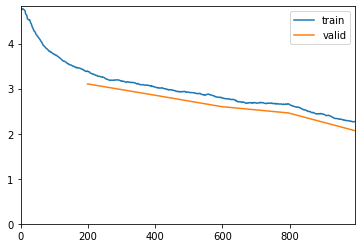


Run: 2


epoch,train_loss,valid_loss,accuracy,time
0,3.385556,3.091324,0.305765,00:54
1,3.041798,2.918486,0.379041,00:54
2,2.857871,2.635966,0.427532,00:55
3,2.648901,2.511872,0.486800,00:54
4,2.259285,2.089601,0.616110,00:54


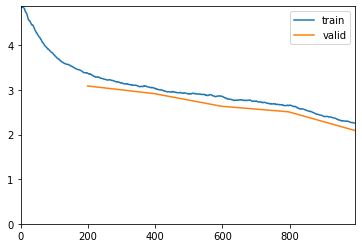


Run: 3


epoch,train_loss,valid_loss,accuracy,time
0,3.407103,3.126490,0.297683,00:54
1,3.031661,2.860991,0.389547,00:55
2,2.812625,2.569441,0.459591,00:54
3,2.613002,2.397639,0.514278,00:55
4,2.274783,2.073626,0.618804,00:55


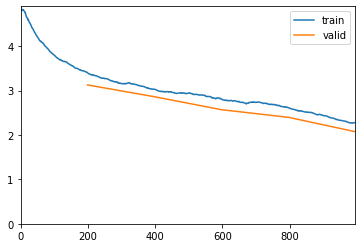


Run: 4


epoch,train_loss,valid_loss,accuracy,time
0,3.402472,3.138440,0.299300,00:54
1,3.059836,2.850256,0.379580,00:54
2,2.819857,2.608787,0.455011,00:54
3,2.664368,2.378666,0.518050,00:54
4,2.284824,2.058285,0.633082,00:55


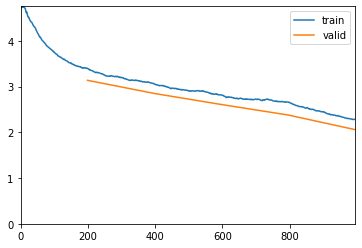


Run: 5


epoch,train_loss,valid_loss,accuracy,time
0,3.411885,3.066490,0.309806,00:54
1,3.073772,2.844162,0.388470,00:54
2,2.839847,2.656106,0.420259,00:54
3,2.682036,2.511681,0.474677,00:55
4,2.314883,2.100731,0.617457,00:54


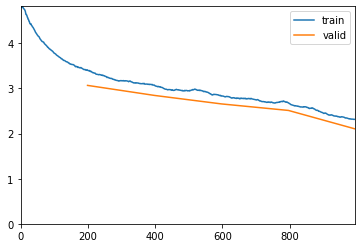

Average Val Acc: 62.35% ±0.83%
Average Val Loss: 2.08 ±0.02


([0.6320043206214905,
  0.6161099076271057,
  0.618803858757019,
  0.6330819129943848,
  0.6174569129943848],
 [2.063842296600342,
  2.0896008014678955,
  2.0736260414123535,
  2.0582845211029053,
  2.100731372833252],
 <fastai2.learner.Learner at 0x7ff59a737ad0>)

In [59]:
do_train(runs=5, num_ep=5, lr1=1e-2)

In [60]:
learn=None
del learn
torch.cuda.empty_cache()
gc.collect()
print('')

# 15b. Baseline reference + RRC (scale 0.7), no zoom, fct_pct=0.5

In [61]:
def get_dls(sz=224, bs=64, partial=False):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[RandomResizedCrop(sz)],
                      batch_tfms=[*aug_transforms(max_zoom=1.0)])
    if partial: 
        partial_frac = 0.5
        partial_n = int(12753 * partial_frac)
        xtra_kwargs = [{}] * (2-1) #(self.n_subsets-1)
        dls = block.dataloaders('', bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs))
    else: dls = block.dataloaders('', bs=bs)
    return dls

In [62]:
def do_train(runs=1,  num_ep=5, lr1=1e-2, lr2=2e-3):
    acc_res,val_res=[],[]
    #stg_1_num_ep = 4
    cbs=[] #[ColorfulProgressCallback()],[WandbCallback()]
    for r in range(runs):
        print(f'Run: {r+1}')      
        # STG 1 - Fit 5e
        dls = get_dls(sz=224)
        m=xresnet50(pretrained=False, sa=True, act_cls=Mish, n_out=dls.c)
        loss_func=LabelSmoothingCrossEntropy()
        learn = Learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, 
                        splitter=xresnet50_splitter).to_fp16()
        learn.unfreeze()
        learn.fit_flat_cos(num_ep, lr1, pct_start=0.5, cbs=ShowGraphCallback())
        
        # LOG
        acc_res.append(learn.final_record[2])
        val_res.append(learn.final_record[1])
        # CLEAR MEM
        if r < runs-1:
            learn=None
            del learn
            torch.cuda.empty_cache()
            gc.collect()
            print('')
    
    if len(acc_res) > 1:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}% ±{(stdev(acc_res)*100):.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f} ±{stdev(val_res):.2f}')
    else:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f}')
    return acc_res, val_res, learn

Run: 1


epoch,train_loss,valid_loss,accuracy,time
0,3.389404,3.152220,0.283405,00:54
1,3.069487,2.931819,0.345097,00:54
2,2.838717,2.649993,0.448545,00:54
3,2.541729,2.314293,0.537715,00:55
4,2.278537,2.126533,0.601832,00:55


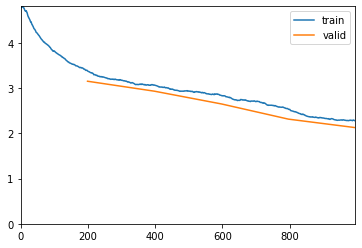


Run: 2


epoch,train_loss,valid_loss,accuracy,time
0,3.365025,3.100354,0.319504,00:54
1,3.020953,2.817098,0.376078,00:55
2,2.822120,2.524447,0.467403,00:55
3,2.510058,2.275845,0.549030,00:55
4,2.235863,2.084635,0.619612,00:55


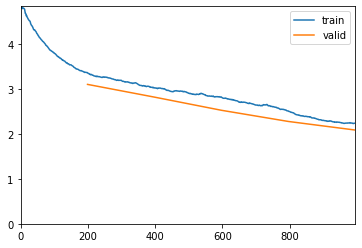


Run: 3


epoch,train_loss,valid_loss,accuracy,time
0,3.381607,3.198185,0.299300,00:54
1,3.023382,2.767383,0.393050,00:55
2,2.795524,2.638415,0.453125,00:55
3,2.485504,2.259442,0.559806,00:55
4,2.210441,2.075444,0.624731,00:55


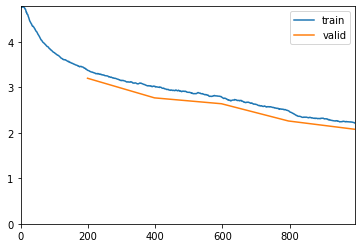


Run: 4


epoch,train_loss,valid_loss,accuracy,time
0,3.431305,3.194595,0.276940,00:54
1,3.087625,2.868922,0.376616,00:54
2,2.858563,2.565565,0.466325,00:55
3,2.519993,2.237843,0.578125,00:55
4,2.247676,2.104746,0.624731,00:55


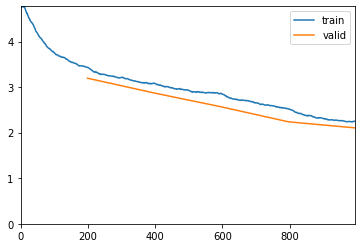


Run: 5


epoch,train_loss,valid_loss,accuracy,time
0,3.406564,3.119642,0.290409,00:54
1,3.039073,2.798097,0.378502,00:55
2,2.819181,2.621473,0.433459,00:55
3,2.507746,2.293291,0.554957,00:55
4,2.246819,2.082059,0.626616,00:55


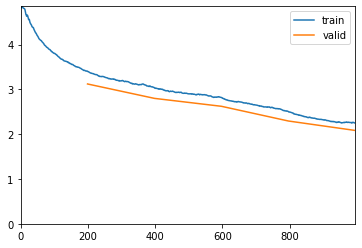

Average Val Acc: 61.95% ±1.02%
Average Val Loss: 2.09 ±0.02


([0.6018319129943848,
  0.6196120977401733,
  0.6247305870056152,
  0.6247305870056152,
  0.626616358757019],
 [2.126533269882202,
  2.08463454246521,
  2.075444221496582,
  2.104745864868164,
  2.082059144973755],
 <fastai2.learner.Learner at 0x7ff553f4c890>)

In [63]:
do_train(runs=5, num_ep=5, lr1=1e-2)

In [64]:
learn=None
del learn
torch.cuda.empty_cache()
gc.collect()
print('')

# 16. FixRes 160/224, 3.5/1.5, Resize, no frozen augs, ffc 0.75

In [65]:
def get_dls(sz=224, bs=64, partial=False, p_frac=0.5):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[*aug_transforms()])
    if partial: 
        partial_frac = p_frac
        partial_n = int(12753 * partial_frac)
        xtra_kwargs = [{}] * (2-1) #(self.n_subsets-1)
        dls = block.dataloaders('', bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs))
    else: dls = block.dataloaders('', bs=bs)
    return dls

In [66]:
def get_fzn_dls(sz=224, bs=64, partial=False, p_frac=0.5):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[])
    if partial: 
        partial_frac = p_frac
        partial_n = int(12753 * partial_frac)
        xtra_kwargs = [{}] * (2-1) #(self.n_subsets-1)
        dls = block.dataloaders('', bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs))
    else: dls = block.dataloaders('', bs=bs)
    return dls

In [67]:
def do_train(runs=1,  num_ep=5, lr1=1e-2, lr2=2e-3):
    acc_res,val_res=[],[]
    stg_1_num_ep = 3
    cbs=[] #[ColorfulProgressCallback()],[WandbCallback()]
    for r in range(runs):
        print(f'Run: {r+1}')      
        dls = get_dls(sz=160)

        m=xresnet50(pretrained=False, sa=True, act_cls=Mish, n_out=dls.c)
        loss_func=LabelSmoothingCrossEntropy()

        learn = Learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, 
                        splitter=xresnet50_splitter).to_fp16()
        learn.unfreeze()
        
        # STG 1
        learn.fit(stg_1_num_ep, lr1, cbs=ShowGraphCallback())
        
        # STG 2 - PartialDL (0.5)
        dls = get_dls(sz=160, partial=True)
        learn.dls=dls
        learn.fit_flat_cos(1, lr1, pct_start=0.25, cbs=ShowGraphCallback())
        
        # STG 3 - PartialDL (0.5)
        dls = get_fzn_dls(sz=224, partial=True)
        learn.dls = dls
        learn.freeze()
        learn.fit(1, lr2, cbs=ShowGraphCallback())
        
        # STG 4 - 1
        dls = get_fzn_dls(sz=224, partial=False)
        learn.dls = dls
        learn.freeze()
        learn.fit_flat_cos(1, lr2, pct_start=0.25, cbs=ShowGraphCallback())
        
        # LOG
        acc_res.append(learn.final_record[2])
        val_res.append(learn.final_record[1])
        # CLEAR MEM
        if r < runs-1:
            learn=None
            del learn
            torch.cuda.empty_cache()
            gc.collect()
            print('')
    
    if len(acc_res) > 1:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}% ±{(stdev(acc_res)*100):.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f} ±{stdev(val_res):.2f}')
    else:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f}')
    return acc_res, val_res, learn

Run: 1


epoch,train_loss,valid_loss,accuracy,time
0,3.252215,3.043262,0.307651,00:33
1,2.829512,2.713022,0.436422,00:33
2,2.443884,2.465425,0.517511,00:33


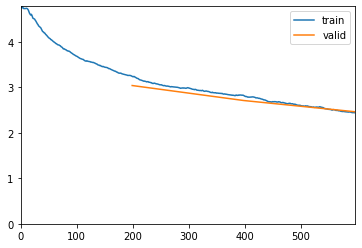

epoch,train_loss,valid_loss,accuracy,time
0,2.090261,2.123411,0.606412,00:18


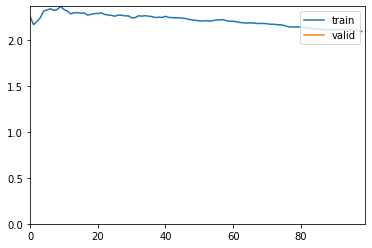

epoch,train_loss,valid_loss,accuracy,time
0,1.960430,2.047889,0.631735,00:23


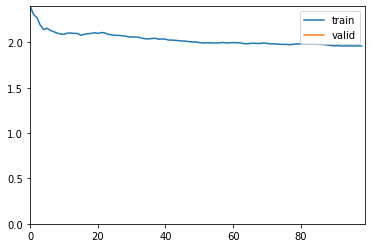

epoch,train_loss,valid_loss,accuracy,time
0,1.862147,1.929980,0.676994,00:42


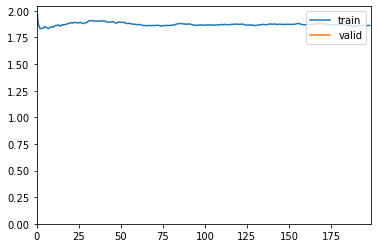


Run: 2


epoch,train_loss,valid_loss,accuracy,time
0,3.206430,2.976213,0.333513,00:33
1,2.743201,2.706251,0.440194,00:33
2,2.409977,2.319282,0.550647,00:33


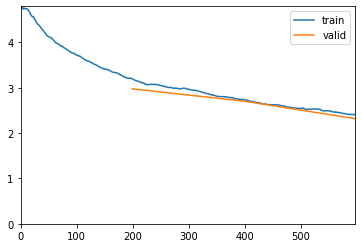

epoch,train_loss,valid_loss,accuracy,time
0,2.079537,2.063714,0.626616,00:18


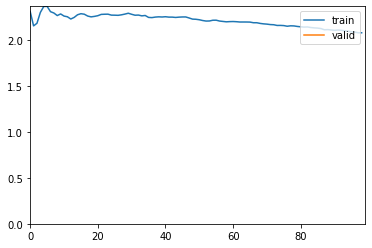

epoch,train_loss,valid_loss,accuracy,time
0,1.903135,2.009034,0.655442,00:23


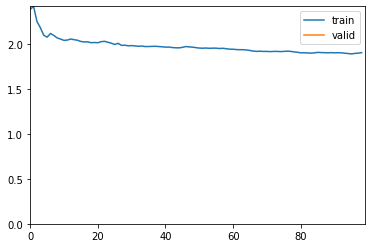

epoch,train_loss,valid_loss,accuracy,time
0,1.813962,1.877616,0.697468,00:42


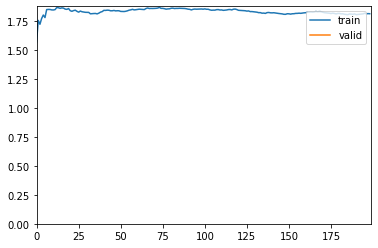


Run: 3


epoch,train_loss,valid_loss,accuracy,time
0,3.254699,3.052343,0.316810,00:33
1,2.785352,2.636658,0.441272,00:33
2,2.456909,2.578977,0.476024,00:34


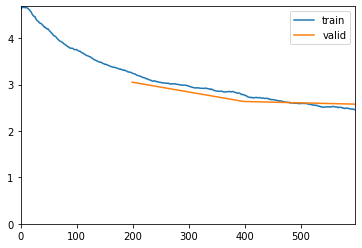

epoch,train_loss,valid_loss,accuracy,time
0,2.106406,2.120887,0.609375,00:18


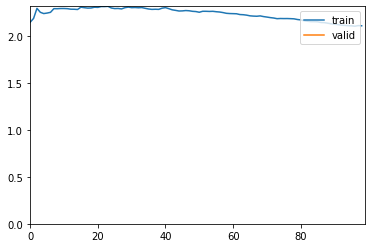

epoch,train_loss,valid_loss,accuracy,time
0,1.936297,2.060735,0.634968,00:23


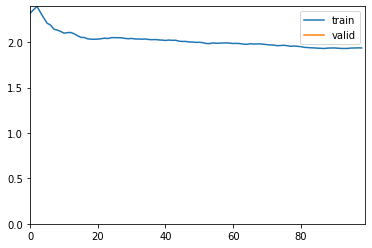

epoch,train_loss,valid_loss,accuracy,time
0,1.869827,1.927095,0.682381,00:42


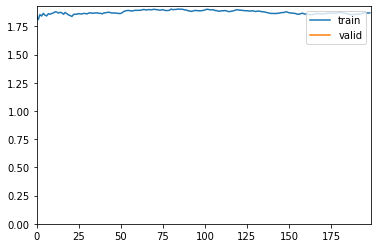


Run: 4


epoch,train_loss,valid_loss,accuracy,time
0,3.240623,3.051913,0.326778,00:33
1,2.799890,2.880030,0.379849,00:33


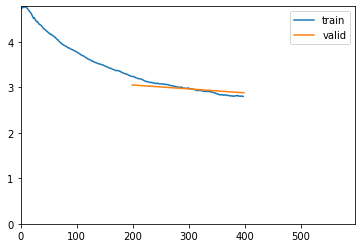

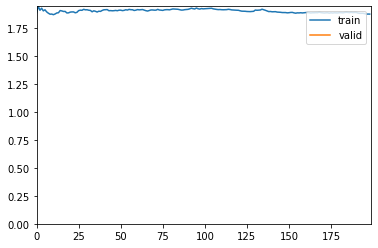


Run: 5


epoch,train_loss,valid_loss,accuracy,time
0,3.225540,2.959182,0.339709,00:33
1,2.736425,2.672305,0.433459,00:33
2,2.435238,2.332915,0.544181,00:33


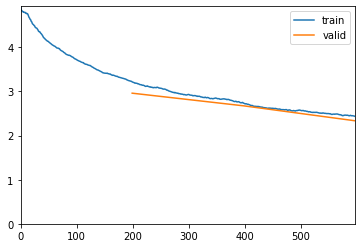

epoch,train_loss,valid_loss,accuracy,time
0,2.108034,2.072189,0.623653,00:18


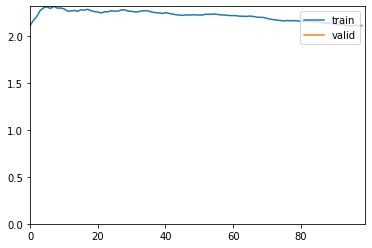

epoch,train_loss,valid_loss,accuracy,time
0,1.914641,2.025514,0.640894,00:23


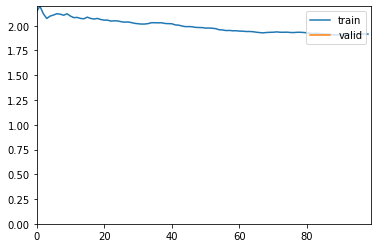

epoch,train_loss,valid_loss,accuracy,time
0,1.828248,1.882352,0.686692,00:42


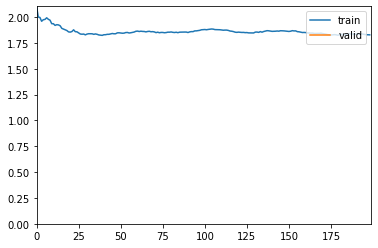

Average Val Acc: 68.35% ±0.93%
Average Val Loss: 1.91 ±0.03


In [68]:
acc_res, val_res, learn = do_train(runs=5,  num_ep=5, lr1=1e-2, lr2=1e-2)

# 17. FixRes 224/224, 4.5/0.5, Resize, no frozen augs, fit, ffc, ffc

In [73]:
def get_dls(sz=224, bs=64, partial=False):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[*aug_transforms()])
    if partial: 
        partial_frac = 0.5
        partial_n = int(12753 * partial_frac)
        xtra_kwargs = [{}] * (2-1) #(self.n_subsets-1)
        dls = block.dataloaders('', bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs))
    else: dls = block.dataloaders('', bs=bs)
    return dls

In [74]:
def get_fzn_dls(sz=224, bs=64, partial=False):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[])
    if partial: 
        partial_frac = 0.5
        partial_n = int(12753 * partial_frac)
        xtra_kwargs = [{}] * (2-1) #(self.n_subsets-1)
        dls = block.dataloaders('', bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs))
    else: dls = block.dataloaders('', bs=bs)
    return dls

In [75]:
def do_train(runs=1,  num_ep=5, lr1=1e-2, lr2=2e-3):
    acc_res,val_res=[],[]
    stg_1_num_ep = 4
    cbs=[] #[ColorfulProgressCallback()],[WandbCallback()]
    for r in range(runs):
        print(f'Run: {r+1}')    
        dls = get_dls(sz=160)

        m=xresnet50(pretrained=False, sa=True, act_cls=Mish, n_out=dls.c)
        loss_func=LabelSmoothingCrossEntropy()

        learn = Learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, 
                        splitter=xresnet50_splitter).to_fp16()
         # STG 1 - Fit 4e
        learn.unfreeze()
        learn.fit(stg_1_num_ep, lr1, cbs=ShowGraphCallback())
        
        # STG 2 - PartialDL (0.5)
        dls = get_dls(sz=224, partial=True)
        learn.dls=dls
        learn.fit_flat_cos(1, lr1, cbs=ShowGraphCallback())
        
        # STG 3 - PartialDL (0.5)
        dls = get_fzn_dls(sz=224, partial=True)
        learn.dls = dls
        learn.freeze()
        learn.fit_flat_cos(1, lr2, cbs=ShowGraphCallback())
        
        # LOG
        acc_res.append(learn.final_record[2])
        val_res.append(learn.final_record[1])
        # CLEAR MEM
        if r < runs-1:
            learn=None
            del learn
            torch.cuda.empty_cache()
            gc.collect()
            print('')
    
    if len(acc_res) > 1:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}% ±{(stdev(acc_res)*100):.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f} ±{stdev(val_res):.2f}')
    else:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f}')
    return acc_res, val_res, learn

Run: 1


epoch,train_loss,valid_loss,accuracy,time
0,3.221664,3.037361,0.310345,00:32
1,2.822843,2.856710,0.371228,00:32
2,2.527611,2.416640,0.517511,00:33
3,2.294219,2.289668,0.557651,00:33


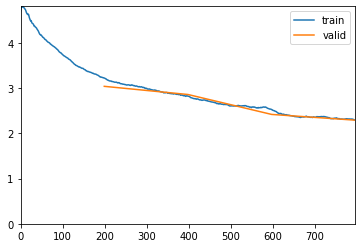

epoch,train_loss,valid_loss,accuracy,time
0,2.039471,2.008254,0.637392,00:29


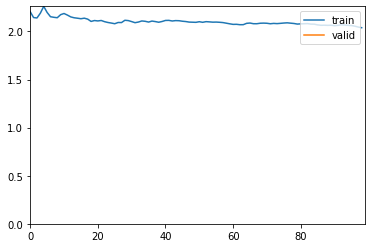

epoch,train_loss,valid_loss,accuracy,time
0,1.783132,1.882988,0.690733,00:23


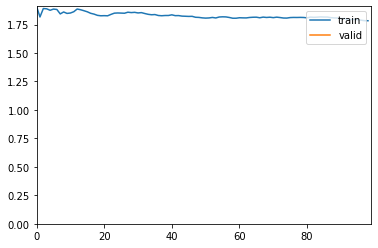


Run: 2


epoch,train_loss,valid_loss,accuracy,time
0,3.242281,2.916090,0.358836,00:33
1,2.824232,2.774844,0.407866,00:33
2,2.540506,2.672533,0.445582,00:33
3,2.303668,2.288420,0.543642,00:33


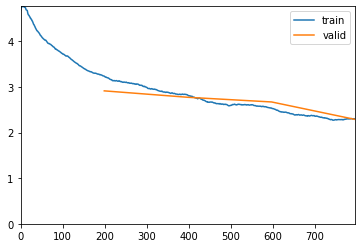

epoch,train_loss,valid_loss,accuracy,time
0,2.027790,2.000615,0.656519,00:29


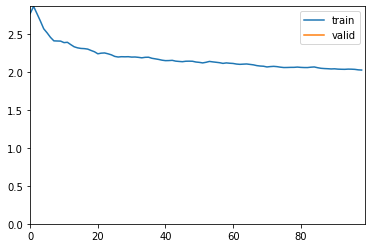

epoch,train_loss,valid_loss,accuracy,time
0,1.745725,1.894289,0.685884,00:23


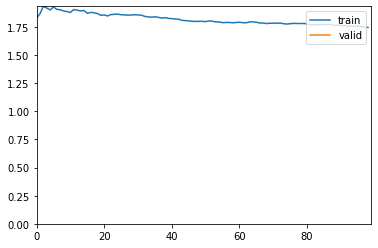


Run: 3


epoch,train_loss,valid_loss,accuracy,time
0,3.275802,3.030447,0.320043,00:33
1,2.832764,2.875973,0.376616,00:33
2,2.518331,2.495138,0.490302,00:33
3,2.268782,2.276812,0.573545,00:33


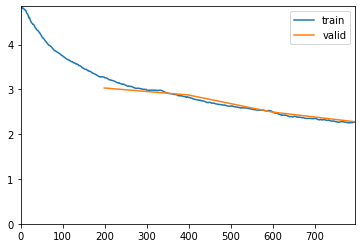

epoch,train_loss,valid_loss,accuracy,time
0,1.986134,1.995712,0.649515,00:29


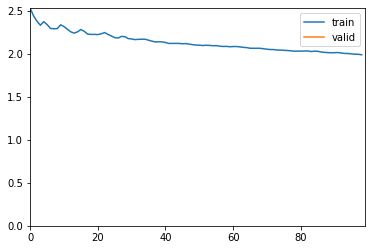

epoch,train_loss,valid_loss,accuracy,time
0,1.751394,1.868490,0.689655,00:23


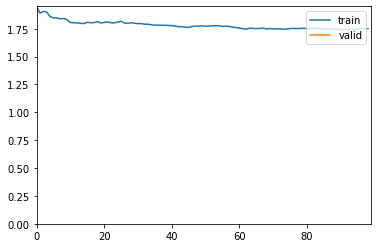


Run: 4


epoch,train_loss,valid_loss,accuracy,time
0,3.186365,3.004556,0.324084,00:33
1,2.729577,2.745864,0.423491,00:33
2,2.397405,2.370560,0.530442,00:33


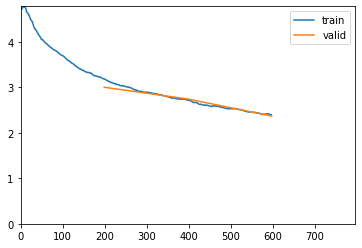

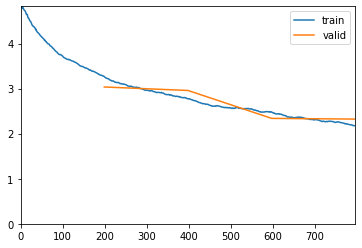

epoch,train_loss,valid_loss,accuracy,time
0,1.969223,1.963442,0.671606,00:29


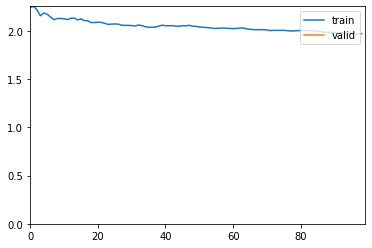

epoch,train_loss,valid_loss,accuracy,time
0,1.720679,1.828487,0.712285,00:23


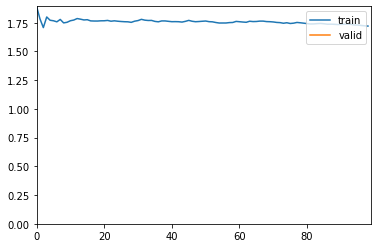

Average Val Acc: 70.10% ±1.76%
Average Val Loss: 1.85 ±0.04


In [76]:
acc_res, val_res, learn = do_train(runs=5,  num_ep=5, lr1=1e-2, lr2=1e-2)

# 18. 20e - FixRes 192/224, 4.5/0.5, Resize, no frozen augs, ffc 0.75

In [26]:
def get_dls(sz=224, bs=64, partial=False):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[*aug_transforms()])
    if partial: 
        partial_frac = 0.5
        partial_n = int(12753 * partial_frac)
        xtra_kwargs = [{}] * (2-1) #(self.n_subsets-1)
        dls = block.dataloaders('', bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs))
    else: dls = block.dataloaders('', bs=bs)
    return dls

In [27]:
def get_fzn_dls(sz=224, bs=64, partial=False):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[])
    if partial: 
        partial_frac = 0.5
        partial_n = int(12753 * partial_frac)
        xtra_kwargs = [{}] * (2-1) #(self.n_subsets-1)
        dls = block.dataloaders('', bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs))
    else: dls = block.dataloaders('', bs=bs)
    return dls

In [28]:
def do_train(runs=1,  num_ep=5, lr1=1e-2, lr2=2e-3):
    acc_res,val_res=[],[]
    stg_1_num_ep = 16
    cbs=[] #[ColorfulProgressCallback()],[WandbCallback()]
    for r in range(runs):
        print(f'Run: {r+1}')      
        # STG 1 - Fit 4e
        dls = get_dls(sz=192)

        m=xresnet50(pretrained=False, sa=True, act_cls=Mish, n_out=dls.c)
        loss_func=LabelSmoothingCrossEntropy()

        learn = Learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, 
                        splitter=xresnet50_splitter).to_fp16()
        learn.unfreeze()
        learn.fit_flat_cos(stg_1_num_ep, lr1, cbs=ShowGraphCallback())
        
#         # STG 2 - PartialDL (0.5)
#         dls = get_dls(sz=192, partial=True)
#         learn.dls=dls
#         learn.fit_flat_cos(1, lr1, cbs=ShowGraphCallback())
        
        # STG 2 - PartialDL (0.5)
        dls = get_fzn_dls(sz=224, partial=True)
        learn.dls = dls
        learn.freeze()
        learn.fit_flat_cos(num_ep-stg_1_num_ep, lr2, cbs=ShowGraphCallback())
        
        # LOG
        acc_res.append(learn.final_record[2])
        val_res.append(learn.final_record[1])
        # CLEAR MEM
        if r < runs-1:
            learn=None
            del learn
            torch.cuda.empty_cache()
            gc.collect()
            print('')
    
    if len(acc_res) > 1:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}% ±{(stdev(acc_res)*100):.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f} ±{stdev(val_res):.2f}')
    else:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f}')
    return acc_res, val_res, learn

Run: 1


epoch,train_loss,valid_loss,accuracy,time
0,3.264278,3.109709,0.288524,00:41
1,2.796259,2.751607,0.407597,00:42
2,2.480659,2.258591,0.563578,00:42
3,2.204150,2.287970,0.560075,00:42
4,2.049145,2.315675,0.523707,00:42
5,1.882282,1.995973,0.643858,00:42
6,1.735414,2.035137,0.645474,00:42
7,1.658495,1.814142,0.713631,00:42
8,1.542190,1.902517,0.697198,00:42
9,1.470975,1.693911,0.766703,00:42


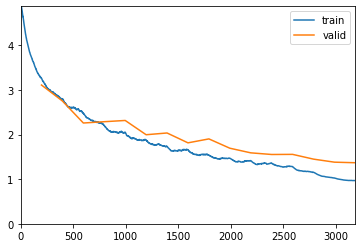

epoch,train_loss,valid_loss,accuracy,time
0,0.961422,1.384446,0.845097,00:25
1,0.954886,1.383023,0.849407,00:23
2,0.958640,1.414863,0.841864,00:23
3,0.940641,1.372944,0.856142,00:23


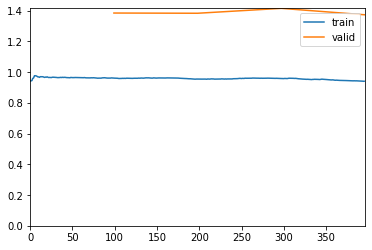

Average Val Acc: 85.61%
Average Val Loss: 1.37


In [29]:
acc_res, val_res, learn = do_train(runs=1,  num_ep=20, lr1=1e-2, lr2=1e-2)

# 19. 20e - 224 Baseline

In [30]:
def get_dls(sz=224, bs=64, partial=False):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                      get_items=get_items,
                      get_x=get_x,
                      get_y=get_y,
                      splitter=splitter,
                      item_tfms=[Resize(sz)],
                      batch_tfms=[*aug_transforms()])
    if partial: 
        partial_frac = 0.5
        partial_n = int(12753 * partial_frac)
        xtra_kwargs = [{}] * (2-1) #(self.n_subsets-1)
        dls = block.dataloaders('', bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs))
    else: dls = block.dataloaders('', bs=bs)
    return dls

In [31]:
def do_train(runs=1,  num_ep=5, lr1=1e-2, lr2=2e-3):
    acc_res,val_res=[],[]
    #stg_1_num_ep = 16
    cbs=[] #[ColorfulProgressCallback()],[WandbCallback()]
    for r in range(runs):
        print(f'Run: {r+1}')      
        # STG 1 - Fit 4e
        dls = get_dls(sz=224)

        m=xresnet50(pretrained=False, sa=True, act_cls=Mish, n_out=dls.c)
        loss_func=LabelSmoothingCrossEntropy()

        learn = Learner(dls, m, opt_func=ranger, loss_func=loss_func, metrics=accuracy, 
                        splitter=xresnet50_splitter).to_fp16()
        learn.unfreeze()
        learn.fit_flat_cos(num_ep, lr1, cbs=ShowGraphCallback())
        
        # LOG
        acc_res.append(learn.final_record[2])
        val_res.append(learn.final_record[1])
        # CLEAR MEM
        if r < runs-1:
            learn=None
            del learn
            torch.cuda.empty_cache()
            gc.collect()
            print('')
    
    if len(acc_res) > 1:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}% ±{(stdev(acc_res)*100):.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f} ±{stdev(val_res):.2f}')
    else:
        print(f'Average Val Acc: {(sum(acc_res)/len(acc_res))*100:.2f}%')
        print(f'Average Val Loss: {sum(val_res)/len(val_res):.2f}')
    return acc_res, val_res, learn

Run: 1


epoch,train_loss,valid_loss,accuracy,time
0,3.271984,3.024537,0.324623,00:53
1,2.812855,2.761778,0.402748,00:54
2,2.560627,2.446906,0.506735,00:54
3,2.311425,2.303977,0.562769,00:54
4,2.114551,2.229366,0.582705,00:54
5,1.941736,2.185070,0.589978,00:55
6,1.777062,2.252037,0.577047,00:55
7,1.665401,1.891180,0.699892,00:55
8,1.589723,1.880794,0.701778,00:55
9,1.492648,1.611961,0.790140,00:55


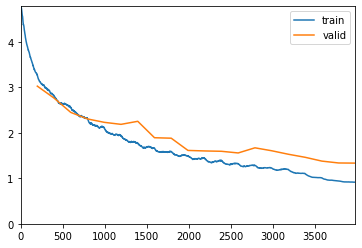

Average Val Acc: 86.93%
Average Val Loss: 1.33


In [32]:
acc_res, val_res, learn = do_train(runs=1,  num_ep=20, lr1=1e-2, lr2=1e-2)